In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re

import time
import torch
import torch.nn

import random
import pickle

# import self-defined module
from utils_eval import AverageMeter

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
4
Tesla V100-SXM2-32GB


In [3]:
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    device = torch.device("cuda:2")
    # work on a single GPU or CPU
    cudnn.benchmark=True
else:
    device = torch.device("cpu")
    cudnn.benchmark=False

print(device)
print(torch.cuda.get_device_name(0))

cuda:2
Tesla V100-SXM2-32GB


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load data

### a. Microbiome & metadata (SHOGUN)

In [5]:
### Read SHOGUN microbiome data - Voom-SNM-Quantile-Data
microbiome_shogun = pd.read_csv('./data/SHOGUN-TCGA-Voom-SNM-Quantile-Data-13517-Samples.csv', 
                               header=0, index_col=0)
### Read Metadata
metadata_shogun = pd.read_csv('./data/Metadata-TCGA-SHOGUN-13517-Samples.csv', 
                               header=0, index_col=0)

#### Merge microbime data and metadata

In [6]:
metadata_subset = metadata_shogun[['case_uuid', 'sample_uuid', 'experimental_strategy', 'sample_type']]
microbiome_metadata_shogun_df = pd.merge(left=microbiome_shogun, right=metadata_subset, how='left', 
                                         left_index=True, right_index=True)
microbiome_metadata_shogun_df['sample_uuid'] = [microbiome_metadata_shogun_df['sample_uuid'].values[i].lower() \
                                                for i in range(microbiome_metadata_shogun_df.shape[0])]

### b. Mutation/CNV and clinical varaibles

In [8]:
microbiome_metadata_shogun_df

k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Sulfolobales.f__Sulfolobaceae.g__Sulfolobus  \
s159                                          -0.465401                                            
s150                                          11.036542                                            
s160                                          10.735982                                            
s173                                           4.277380                                            
s106                                           8.872817                                            
...                                                 ...                                            
s205                                          11.751580                                            
s260                                          11.090010                                            
s198                                          12.598790                                            
s317                                          14.570110                                            
s327                                          14.798800                                            

      k__Archaea.p__Euryarchaeota.c__Thermoplasmata.o__Thermoplasmatales.f__Ferroplasmaceae.g__Acidiplasma  \
s159                                           6.508585                                                      
s150                                          12.018787                                                      
s160                                           6.508585                                                      
s173                                           6.508585                                                      
s106                                          14.158892                                                      
...                                                 ...                                                      
s205                                          11.842400                                                      
s260                                          11.997960                                                      
s198                                          11.842400                                                      
s317                                          14.708940                                                      
s327                                          13.533790                                                      

      k__Bacteria.__.__.__.__.__  k__Bacteria.p__.c__.o__.f__.g__  \
s159                   20.285959                         4.731833   
s150                   20.285959                         4.731833   
s160                   18.048346                         4.731833   
s173                   18.048346                         4.731833   
s106                   20.285959                         4.731833   
...                          ...                              ...   
s205                   19.950120                         5.209011   
s260                   20.731470                         5.231098   
s198                   19.102910                         5.209011   
s317                   20.232590                         5.019191   
s327                   20.411650                         4.997104   

      k__Bacteria.p__Actinobacteria.__.__.__.__  \
s159                                  -1.465741   
s150                                  -1.465741   
s160                                  -1.465741   
s173                                  -1.465741   
s106                                  -1.465741   
...                                         ...   
s205                                  -1.163423   
s260                                  -1.144627   
s198                                  -1.163423   
s317                                  -1.338791   
s327                                  -1.357586   

      k__Bacteria.p__Actinobacteria.c__Act

In [9]:
mutation_cnv_df

AMP.CCND1  AMP.CCND2  AMP.CCND3  AMP.CCNE1  AMP.CDK4  \
SAMPLE_BARCODE                                                          
TCGA-OR-A5J1-01      False      False      False       True     False   
TCGA-OR-A5J2-01      False      False      False      False     False   
TCGA-OR-A5J3-01      False      False      False      False     False   
TCGA-OR-A5J5-01      False      False      False      False     False   
TCGA-OR-A5J6-01      False      False      False      False     False   
...                    ...        ...        ...        ...       ...   
TCGA-YZ-A980-01      False      False      False      False     False   
TCGA-YZ-A982-01      False      False      False      False     False   
TCGA-YZ-A983-01      False      False      False      False     False   
TCGA-YZ-A984-01      False      False      False      False     False   
TCGA-YZ-A985-01      False      False      False      False     False   

                 AMP.CDK6  AMP.E2F1  AMP.E2F3  AMP.YAP1  AMP.MYC  ...  \
SAMPLE_BARCODE                                                    ...   
TCGA-OR-A5J1-01     False     False     False     False    False  ...   
TCGA-OR-A5J2-01     False     False     False     False    False  ...   
TCGA-OR-A5J3-01     False     False     False     False    False  ...   
TCGA-OR-A5J5-01     False     False     False     False    False  ...   
TCGA-OR-A5J6-01     False     False     False     False    False  ...   
...                   ...       ...       ...       ...      ...  ...   
TCGA-YZ-A980-01     False     False     False     False    False  ...   
TCGA-YZ-A982-01     False     False     False     False    False  ...   
TCGA-YZ-A983-01     False     False     False     False    False  ...   
TCGA-YZ-A984-01     False     False     False     False    False  ...   
TCGA-YZ-A985-01     False     False     False     False    False  ...   

                 FUSION.TGFBR2  FUSION.TLE3  FUSION.TP53  FUSION.TSC1  \
SAMPLE_BARCODE                                                          
TCGA-OR-A5J1-01          False        False        False        False   
TCGA-OR-A5J2-01          False        False        False        False   
TCGA-OR-A5J3-01          False        False        False        False   
TCGA-OR-A5J5-01          False        False        False        False   
TCGA-OR-A5J6-01          False        False        False        False   
...                        ...          ...          ...          ...   
TCGA-YZ-A980-01          False        False        False        False   
TCGA-YZ-A982-01          False        False        False        False   
TCGA-YZ-A983-01          False        False        False        False   
TCGA-YZ-A984-01          False        False        False        False   
TCGA-YZ-A985-01          False        False        False        False   

                 FUSION.TSC2  FUSION.WIF1  FUSION.WWC1  FUSION.WWTR1  \
SAMPLE_BARCODE                                                         
TCGA-OR-A5J1-01         True        False        False         False   
TCGA-OR-A5J2-01        False        False        False         False   
TCGA-OR-A5J3-01        False        False        False         False   
TCGA-OR-A5J5-01        False        False        False         False   
TCGA-OR-A5J6-01        False        False        False         False   
...                      ...          ...          ...           ...   
TCGA-YZ-A980-01        False        False        False         False   
TCGA-YZ-A982-01        False        False        False         False   
TCGA-YZ-A983-01        False        False        False         False   
TCGA-YZ-A984-01        False        False        False         False   
TCGA-YZ-A985-01        False        False        False         False   

                 FUSION.YAP1  FUSION.ZNRF3  
SAMPLE_BARCODE                              
TCGA-OR-A5J1-01        False         False  
TCGA-OR-A5J2-01        False         False  
TCGA-OR-A5J3-01        False         False  
TCGA-

In [10]:
clinical_immune_variables_df

PATIENT_BARCODE DISEASE             HLA-A1             HLA-A2  \
SAMPLE_BARCODE                                                                  
TCGA-OR-A5J1-01    TCGA-OR-A5J1     ACC  hla_a_03_01_01_01  hla_a_02_01_01_01   
TCGA-OR-A5J2-01    TCGA-OR-A5J2     ACC  hla_a_03_01_01_01     hla_a_33_01_01   
TCGA-OR-A5J3-01    TCGA-OR-A5J3     ACC     hla_a_23_01_01     hla_a_31_01_02   
TCGA-OR-A5J5-01    TCGA-OR-A5J5     ACC  hla_a_24_02_01_01     hla_a_23_01_01   
TCGA-OR-A5J6-01    TCGA-OR-A5J6     ACC  hla_a_03_01_01_01     hla_a_33_01_01   
...                         ...     ...                ...                ...   
TCGA-YZ-A980-01    TCGA-YZ-A980     UVM  hla_a_24_02_01_01     hla_a_23_01_01   
TCGA-YZ-A982-01    TCGA-YZ-A982     UVM  hla_a_03_01_01_01  hla_a_01_01_01_01   
TCGA-YZ-A983-01    TCGA-YZ-A983     UVM     hla_a_11_01_01  hla_a_24_02_01_01   
TCGA-YZ-A984-01    TCGA-YZ-A984     UVM     hla_a_30_01_01  hla_a_02_01_01_01   
TCGA-YZ-A985-01    TCGA-YZ-A985     UVM     hla_a_11_01_01     hla_a_11_01_01   

                 homo HLA-A =1             HLA-B1             HLA-B2  \
SAMPLE_BARCODE                                                         
TCGA-OR-A5J1-01            0.0     hla_b_07_02_01  hla_b_35_01_01_02   
TCGA-OR-A5J2-01            0.0     hla_b_14_02_01     hla_b_08_01_01   
TCGA-OR-A5J3-01            0.0     hla_b_55_01_01     hla_b_15_05_01   
TCGA-OR-A5J5-01            0.0  hla_b_35_01_01_02     hla_b_40_01_02   
TCGA-OR-A5J6-01            0.0     hla_b_14_02_01     hla_b_15_10_01   
...                        ...                ...                ...   
TCGA-YZ-A980-01            0.0     hla_b_07_02_01  hla_b_18_01_01_01   
TCGA-YZ-A982-01            0.0     hla_b_51_01_01  hla_b_44_02_01_01   
TCGA-YZ-A983-01            0.0        hla_b_18_03  hla_b_35_01_01_02   
TCGA-YZ-A984-01            0.0     hla_b_35_03_01     hla_b_13_02_01   
TCGA-YZ-A985-01            1.0     hla_b_27_05_02  hla_b_52_01_01_02   

                 homo HLA-B =1             HLA-C1             HLA-C2  ...  \
SAMPLE_BARCODE                                                        ...   
TCGA-OR-A5J1-01            0.0  hla_c_12_03_01_01  hla_c_04_01_01_01  ...   
TCGA-OR-A5J2-01            0.0  hla_c_07_01_01_01     hla_c_08_02_01  ...   
TCGA-OR-A5J3-01            0.0     hla_c_01_02_01     hla_c_01_02_01  ...   
TCGA-OR-A5J5-01            0.0  hla_c_03_04_01_01  hla_c_04_01_01_01  ...   
TCGA-OR-A5J6-01            0.0     hla_c_08_02_01     hla_c_03_04_02  ...   
...                        ...                ...                ...  ...   
TCGA-YZ-A980-01            0.0  hla_c_07_02_01_03  hla_c_05_01_01_01  ...   
TCGA-YZ-A982-01            0.0     hla_c_15_02_01  hla_c_05_01_01_02  ...   
TCGA-YZ-A983-01            0.0  hla_c_07_01_01_01  hla_c_04_01_01_05  ...   
TCGA-YZ-A984-01            0.0     hla_c_12_03_08  hla_c_06_02_01_01  ...   
TCGA-YZ-A985-01            0.0     hla_c_01_02_01     hla_c_12_02_02  ...   

                 T Cells CD4 Memory Resting  T Cells CD4 Naive  T Cells CD8  \
SAMPLE_BARCODE                                                                
TCGA-OR-A5J1-01                    0.271379           0.000000     0.135295   
TCGA-OR-A5J2-01                    0.138389           0.000000     0.113243   
TCGA-OR-A5J3-01                    0.110013           0.143165     0.017344   
TCGA-OR-A5J5-01                    0.165923           0.009546     0.061211   
TCGA-OR-A5J6-01                    0.134203           0.000000     0.053699   
...                                     ...                ...          ...   
TCGA-YZ-A980-01                    0.011387           0.000000     0.131042   
TCGA-YZ-A982-01                    0.069677           0.000000     0.020880   
TCGA-YZ-A983-01                    0.063108           0.000000     0.030245   
TCGA-YZ-A984-01                    0.093925           0.000000     0.002201   
TCGA-YZ-A985-01                    0.046712           0.000000     0.064863

In [7]:
### Read molecular signature data
mutation_cnv_df = pd.read_excel('./data/Master Table-Alteration in CNV, Mut, Pathway .xlsx', 
                                 sheet_name='CNV and mutation', header=0, index_col=0)

### Delete the last column
mutation_cnv_df = mutation_cnv_df.drop(columns=[mutation_cnv_df.columns[-1]])

### Read clinical varaible data
clinical_immune_variables_df = pd.read_excel('./data/Master Table-Alteration in CNV, Mut, Pathway .xlsx', sheet_name='Clinical variables', 
                                     header=0, index_col=1, na_values=['[Not Applicable]', '#N/A', '[Not Available]', 
                                                                     '[Discrepancy]', '[Not Evaluated]', '[Unknown]'])

# Remove duplicate columns
import re
for c in clinical_immune_variables_df.columns:
    if re.search('.*[.]\d', c):
        clinical_immune_variables_df = clinical_immune_variables_df.drop(columns = [c])
clinical_immune_variables_df = clinical_immune_variables_df.drop(columns = ['OS Time', 'OS.time (months)', 'OS', 
                                                              'PFI Time', 'DSS.time (days)'])

# 2. Process and merge data

In [8]:
def remove_missing_rows(dataset, microbiome_column_index):
    start_idx = microbiome_column_index[0]
    end_idx = microbiome_column_index[1]
    
    na_idx = np.where(pd.isna(dataset.iloc[:,start_idx:end_idx]).sum(axis=1)==(end_idx-start_idx))[0]
    dataset_nona = dataset.drop(dataset.index[na_idx], axis=0)
    return dataset_nona

In [9]:
def subsetting(dataset, columns, remain_value_list):
    for column, remain_value in zip(columns, remain_value_list):
        idx_remain = np.isin(dataset.loc[:, column], remain_value)
        dataset = dataset.loc[idx_remain, :]
    return dataset

In [10]:
def merge_mutation_microbiome(disease, clinical_immune_variables_df, mutation_cnv_df, microbiome_metadata_shogun_df, 
                              subsetting_columns=['sample_type', 'experimental_strategy'], 
                              remain_value_list=[['Primary Tumor'], ['RNA-Seq']]):
    
    clinical_immune_variables_df_disease = clinical_immune_variables_df.loc[clinical_immune_variables_df['DISEASE'] == disease,:]
    
    mutation_row_idx_disease = np.where(np.isin(mutation_cnv_df.index, 
                                                clinical_immune_variables_df_disease.index))[0]
    mutation_cnv_df_disease = mutation_cnv_df.iloc[mutation_row_idx_disease,:]
    
    print('========================================================================')
    print(disease.upper())
    print('< Mutation/CNV >')
    print('Total sample #:', mutation_cnv_df_disease.shape[0])
    print('Unique sample #:', len(np.unique(mutation_cnv_df_disease.index)))

    ### Biospecimen data

    ### Read biospecimen data from GDC data portal 
    ### Reference: https://www.biostars.org/p/200546/
    import json

    fileName='./data/biospecimen.project-TCGA-{}.2021-10-14.json'.format(disease)

    with open(fileName) as data_file:    
        biospecimen = json.load(data_file)

    id_list = []
    for i in range(len(biospecimen)):
        for j in range(len(biospecimen[i]['samples'])):
            id_list.append([biospecimen[i]['case_id'], biospecimen[i]['samples'][j]['submitter_id'],
                           biospecimen[i]['samples'][j]['sample_id'], biospecimen[i]['samples'][j]['is_ffpe'],
                           biospecimen[i]['samples'][j]['sample_type']])
    id_df = pd.DataFrame(id_list, columns=['case_uuid', 'sample_id', 'sample_uuid', 'is_ffpe', 'sample_type_bs'])
    id_df = id_df.sort_values(by=['sample_id'])
    id_df['sample_id'] = [id_df['sample_id'].values[i][:-1] for i in range(id_df.shape[0])]
    id_df = id_df.drop_duplicates(subset=['sample_id'])

    print('< biospecimen data >')
    print('Biospecimen sample #:', id_df.shape[0])
    print('sample_type_bs:', list(np.unique(id_df['sample_type_bs'])))

    #### Merge mutation/CNV OR clinical data with biospecimen data and microbiome data

    mutation_cnv_df_disease_uuid = pd.merge(left=mutation_cnv_df_disease, right=id_df, 
                                               how='left', left_index=True, right_on='sample_id')
    mutation_cnv_df_disease_microbiome = pd.merge(left=mutation_cnv_df_disease_uuid, 
                                                     right=microbiome_metadata_shogun_df,
                                                     how='left', on='sample_uuid')
    mutation_cnv_df_disease_microbiome.index = mutation_cnv_df_disease_microbiome['sample_id']
    
    ### Remove rows with no corresponding microbiome data
    microbiome_column_index = [mutation_cnv_df_disease_uuid.shape[1], 
                               mutation_cnv_df_disease_microbiome.shape[1]-3]
    mutation_cnv_df_disease_microbiome_nona = remove_missing_rows(mutation_cnv_df_disease_microbiome, 
                                                                     microbiome_column_index)
    mutation_cnv_df_disease_microbiome_clean = subsetting(mutation_cnv_df_disease_microbiome_nona, 
                                                    subsetting_columns, remain_value_list)
    mutation_cnv_df_disease_microbiome_clean.drop_duplicates(subset='sample_id', inplace=True)
    microbiome_clean = mutation_cnv_df_disease_microbiome_clean.iloc[:, microbiome_column_index[0]:microbiome_column_index[1]]
    print('< Merged data >')
    print('Merged data shape:', mutation_cnv_df_disease_microbiome_clean.shape)
    print('Microbiome data shape:', microbiome_clean.shape)
    print('sample_type:', list(np.unique(mutation_cnv_df_disease_microbiome_clean['sample_type'])))
    
    ### Saving data
    import os
    os.makedirs('./data/processed data', exist_ok=True)
    mutation_cnv_df_disease_microbiome_clean.\
        to_pickle('./data/processed data/{}_mutation_cnv_disease_microbiome_clean.pkl'.format(disease))
    microbiome_clean.\
        to_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))

    return mutation_cnv_df_disease_microbiome_clean, microbiome_clean


In [11]:
COAD_mutation_cnv_disease_microbiome_clean, COAD_microbiome_clean = \
    merge_mutation_microbiome(disease='COAD', clinical_immune_variables_df=clinical_immune_variables_df,
                              mutation_cnv_df=mutation_cnv_df,
                              microbiome_metadata_shogun_df=microbiome_metadata_shogun_df,
                              remain_value_list=[['Metastatic', 'Primary Tumor', 'Recurrent Tumor'], ['RNA-Seq']])
STAD_mutation_cnv_disease_microbiome_clean, STAD_microbiome_clean = \
    merge_mutation_microbiome(disease='STAD', clinical_immune_variables_df=clinical_immune_variables_df,
                              mutation_cnv_df=mutation_cnv_df,
                              microbiome_metadata_shogun_df=microbiome_metadata_shogun_df,
                              remain_value_list=[['Primary Tumor'], ['RNA-Seq']])

COAD
< Mutation/CNV >
Total sample #: 341
Unique sample #: 341
< biospecimen data >
Biospecimen sample #: 978
sample_type_bs: ['Blood Derived Normal', 'Metastatic', 'Primary Tumor', 'Recurrent Tumor', 'Solid Tissue Normal']
< Merged data >
Merged data shape: (164, 2011)
Microbiome data shape: (164, 1594)
sample_type: ['Primary Tumor']
STAD
< Mutation/CNV >
Total sample #: 383
Unique sample #: 383
< biospecimen data >
Biospecimen sample #: 940
sample_type_bs: ['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal']
< Merged data >
Merged data shape: (380, 2011)
Microbiome data shape: (380, 1594)
sample_type: ['Primary Tumor']


# 3. Prediction by MLPs

In [12]:
def balanced_over_sampling(X, y, random_seed=123):
    np.random.seed(random_seed)
    unique_value, unique_value_counts = np.unique(y, return_counts=True)
    train_class_max = np.max(unique_value_counts)
    train_samples_idx = []
    for i, y_unique in enumerate(unique_value):
        train_one_class_idx = np.where(y==y_unique)[0]
        train_one_sample_idx = np.concatenate([train_one_class_idx,
                                               np.random.choice(train_one_class_idx, 
                                                                size=train_class_max-len(train_one_class_idx), 
                                                                replace=True)])
        train_samples_idx.append(train_one_sample_idx)
    train_balanced_idx = np.random.permutation(np.concatenate(train_samples_idx))
    return X[train_balanced_idx], y[train_balanced_idx]

In [13]:
class Classifier(torch.nn.Module):
    def __init__(self, n_in_features, net_hidden_structure, n_out_features, dropout_rate):
        super(Classifier, self).__init__()
        net_fcs = []
        structure = net_hidden_structure
        net_in_shape = n_in_features
        for i, net_n_hidden_nodes in enumerate(structure):
            net_fcs.append(torch.nn.Linear(net_in_shape, net_n_hidden_nodes))
            net_fcs.append(torch.nn.BatchNorm1d(net_n_hidden_nodes))
            net_fcs.append(torch.nn.ReLU6())
            net_fcs.append(torch.nn.Dropout(p=dropout_rate))
            net_in_shape = net_n_hidden_nodes
        net_fcs.append(torch.nn.Linear(net_in_shape, n_out_features))
        self.net_fcs = torch.nn.ModuleList(net_fcs)
        
    def forward(self, x):
        net_fcs = self.net_fcs
        for net_fc in net_fcs:
            x = net_fc(x)
        return x

In [14]:
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    """Self-defined dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: microbiome data
            y: response data
        """
        self.X = torch.from_numpy(X).float() if not torch.is_tensor(X) else X.float()
        self.y = torch.LongTensor(y) if not torch.is_tensor(y) else y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
# train function
from utils_eval import AverageMeter

def train(epoch, classifier, criterion, optimizer, train_loader, gradient_clip=3, device='cpu'):
    """
    One epoch training
    """
    
    classifier.train()
    losses = AverageMeter()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ===================forward=====================
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # ===================backward=====================
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), gradient_clip)
        optimizer.step()
        
        # ===================meters=====================
        losses.update(loss.item(), batch_size)
        loss_return = losses.avg
    
    return loss_return

In [16]:
def train_mlp(X,y, disease, batch_size, n_epoch, gradient_clip, dropout_rate, weight_decay,
              lr=0.001, momentum=0.9, random_state=123, device='cuda:0', print_loss=True,
              save_folder='./'):
    
    import torch
    import torch.nn as nn
    import random
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    ### training, testing split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    X_train_balanced, y_train_balanced = balanced_over_sampling(np.array(X_train), np.array(y_train))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y)
    y_train_balanced_le = le.transform(y_train_balanced)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    # train_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_train, dtype='float32')), torch.LongTensor(y_train_le))
    # test_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_test, dtype='float32')), torch.LongTensor(y_test_le))
    
    train_data = Dataset(np.array(X_train_balanced), np.array(y_train_balanced_le))
    test_data = Dataset(np.array(X_test), np.array(y_test_le))
    if X_train_balanced.shape[0]%batch_size==1:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    classifier = Classifier(n_in_features=X.shape[1], net_hidden_structure = [512, 128, 32, 8], 
                            n_out_features=label_dim,
                            dropout_rate=dropout_rate)
    classifier.to(device)
    criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss combines log_softmax and NLLLoss
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
    
    # =========================
    from utils_eval import AverageMeter
    hist = dict()
    hist['train_loss'] = []
    hist['test_loss'] = []

    for epoch in range(n_epoch):
        # Train
        train_loss = train(epoch, classifier, criterion, optimizer, train_loader, gradient_clip=gradient_clip, 
                           device=device)
        hist['train_loss'].append(train_loss)

        # test
        classifier.eval()
        test_losses = AverageMeter()

        with torch.no_grad():
            for idx, (data, target) in enumerate(test_loader):
                batch_size = data.size(0)
                data, target = data.to(device), target.to(device)

                # ===================forward=====================
                outputs = classifier(data)
                test_loss = criterion(outputs, target)
                # ===================meters======================
                test_losses.update(test_loss.item(), batch_size)

            hist['test_loss'].append(test_losses.avg)
        if print_loss:
            print('Epoch {} \ttrain_loss\t{}\ttest_loss\t{}'.format(epoch, train_loss, test_losses.avg))
    
    model_save_path = os.path.join(save_folder, 'models/{}/{}'.format(disease, y.name))
    os.makedirs(model_save_path, exist_ok=True)

    torch.save({
                'epoch': n_epoch,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, os.path.join(model_save_path, '{}.pth'.format(y_train.name)))
    return classifier, optimizer, hist, X_test, y_test_le, classes, (y_train, y_test)

In [17]:
def plot_loss(hist, disease, y, save_folder='./'):
    
    fig = plt.figure(figsize=(16,8))

    plt.plot(np.arange(len(hist['train_loss'])), hist['train_loss'], 
                 label='Training loss', alpha=0.8)

    plt.plot(np.arange(len(hist['test_loss'])), hist['test_loss'], 
                 label='Testing loss', alpha=0.8)

    plt.xlabel('Epoches', fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Loss (Covariate = {})'.format(y.name), fontsize=20)
    plt.legend(fontsize=20)
    plt.show()
    
    figure_save_path = os.path.join(save_folder, 'figures/{}/{}'.format(disease, y.name))
    os.makedirs(figure_save_path, exist_ok=True)
    fig.savefig(os.path.join('./figures/{}/{}/train_val_losses.pdf'.format(disease, y.name)))

In [18]:
def micro_avg_auc(y_test_le, classes, pred_proba):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    y_test = label_binarize(classes[y_test_le], classes=classes)
    if y_test.shape[1]==1:
        y_test = np.hstack((1-y_test, y_test))
    y_score = pred_proba.cpu().numpy()
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [19]:
def predict_mlp(classifier, optimizer, X_test, y_test_le, classes, device='cpu'):
    classifier.eval()
    with torch.no_grad():
        prediction = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device))
        pred_proba = torch.nn.Softmax(dim=1)(prediction)
    y_pred = classes[pred_proba.argmax(axis=1).cpu().numpy()]
    y_test_true = classes[y_test_le]
    
    accuracy = sum(y_pred==y_test_true)/len(y_pred)
    
    from sklearn.metrics import confusion_matrix
    confusion_mat = confusion_matrix(y_test_true, y_pred)
    
    from sklearn.metrics import roc_auc_score
    y_pred_proba = pred_proba[:,1].cpu().numpy() if pred_proba.shape[1]==2 else pred_proba.cpu().numpy()
    auc = roc_auc_score(y_test_true, y_pred_proba)
    
    return pred_proba, y_pred, accuracy, confusion_mat, auc
    

In [20]:
def train_mlp_all_cols(disease, device='cuda:0', save_folder='./', true_percentage_cutoff=0.04):
    
    mutation_cnv_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_mutation_cnv_disease_microbiome_clean.pkl'.format(disease))

    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = mutation_cnv_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_mutation_cnv_all = mutation_cnv_disease_microbiome_clean.iloc[:,:col_idx]

    ### Remove mutation columns that have <4% (or other true % cutoff) mutations for all samples
    y_mutation_cnv_rmv_idx = np.where(y_mutation_cnv_all.apply(np.mean, axis=0) < true_percentage_cutoff)[0]
    y_mutation_cnv_all.drop(columns=y_mutation_cnv_all.columns[y_mutation_cnv_rmv_idx], inplace=True)
    print(y_mutation_cnv_all.shape)

    accuracy_mutation_cnv = []
    auc_mutation_cnv = []
    y_pred_mutation_cnv = []
    confusion_mat_mutation_cnv = []
    pred_proba_mutation_cnv = []
    classes_mutation_cnv = []
    y_train_test_mutation_cnv = []
    
    for i in range(y_mutation_cnv_all.shape[1]):
        classifier, optimizer, hist, X_test, y_test_le, classes, y_train_test = \
            train_mlp(X=X_microbiome, y=y_mutation_cnv_all.iloc[:,i],
            disease=disease, batch_size=32, n_epoch=1000, device=device,
            gradient_clip=2, dropout_rate=0.4, weight_decay=0.1, 
            print_loss=False, save_folder=save_folder)
        plot_loss(hist, disease, y_mutation_cnv_all.iloc[:,i], save_folder=save_folder)
        pred_proba, y_pred, accuracy, confusion_mat, auc = predict_mlp(classifier, optimizer, X_test, y_test_le, 
                                                                       classes, device=device)
        accuracy_mutation_cnv.append(accuracy)
        auc_mutation_cnv.append(auc)
        y_pred_mutation_cnv.append(y_pred)
        confusion_mat_mutation_cnv.append(confusion_mat)
        pred_proba_mutation_cnv.append(pred_proba)
        classes_mutation_cnv.append(classes)
        y_train_test_mutation_cnv.append(y_train_test)

    import os
    result_save_folder = os.path.join(save_folder, 'results/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    
    prediction_result_dict = dict()
    prediction_result_dict['accuracy'] = dict(zip(y_mutation_cnv_all.columns, accuracy_mutation_cnv))
    prediction_result_dict['auc'] = dict(zip(y_mutation_cnv_all.columns, auc_mutation_cnv))
    prediction_result_dict['y_pred'] = dict(zip(y_mutation_cnv_all.columns, y_pred_mutation_cnv))
    prediction_result_dict['confusion_matrix'] = dict(zip(y_mutation_cnv_all.columns, confusion_mat_mutation_cnv))
    prediction_result_dict['pred_proba'] = dict(zip(y_mutation_cnv_all.columns, pred_proba_mutation_cnv))
    prediction_result_dict['classes'] = dict(zip(y_mutation_cnv_all.columns, classes_mutation_cnv))
    prediction_result_dict['y_train_test'] = dict(zip(y_mutation_cnv_all.columns, y_train_test_mutation_cnv))

    with open(os.path.join(result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(prediction_result_dict, f)
    
    return prediction_result_dict

### COAD

(164, 28)


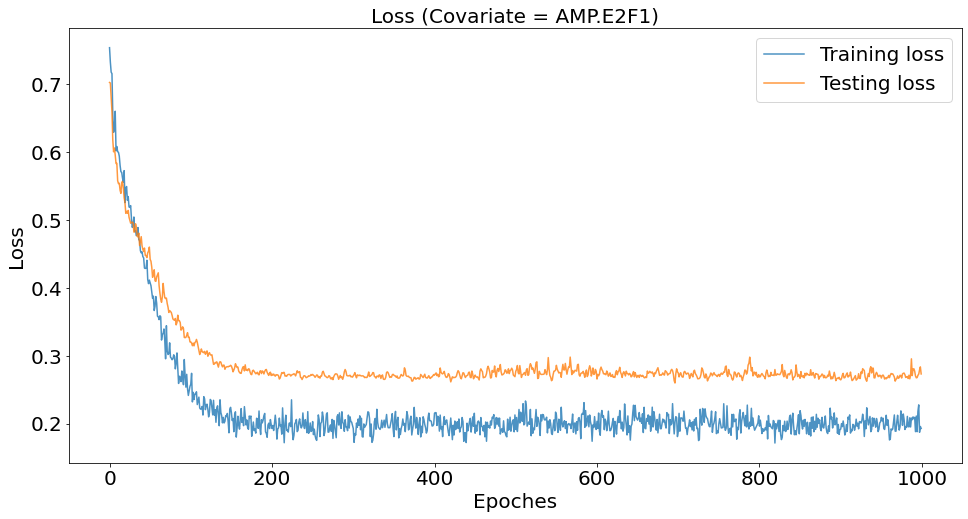

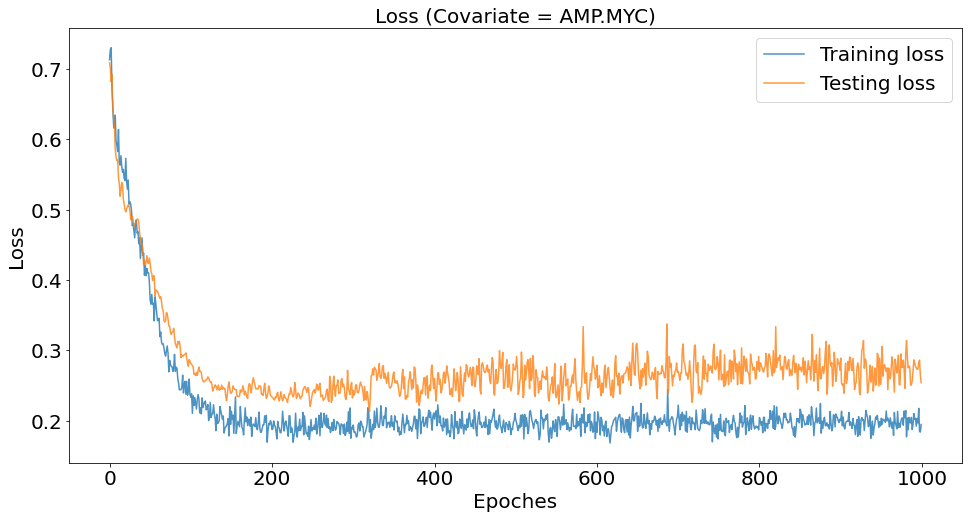

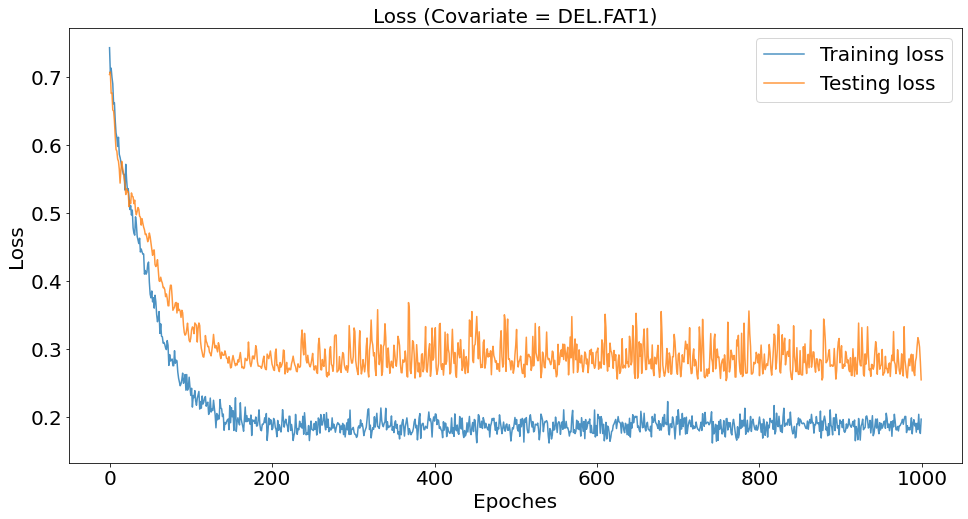

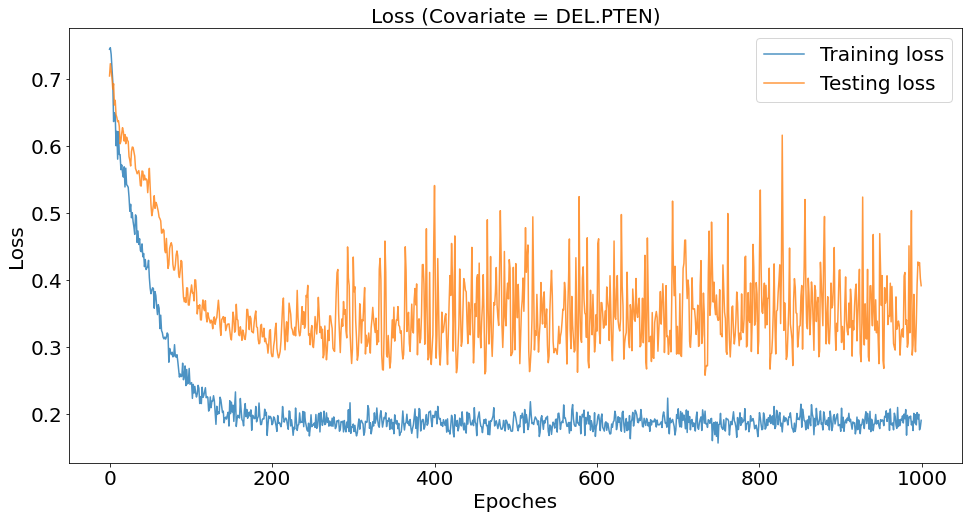

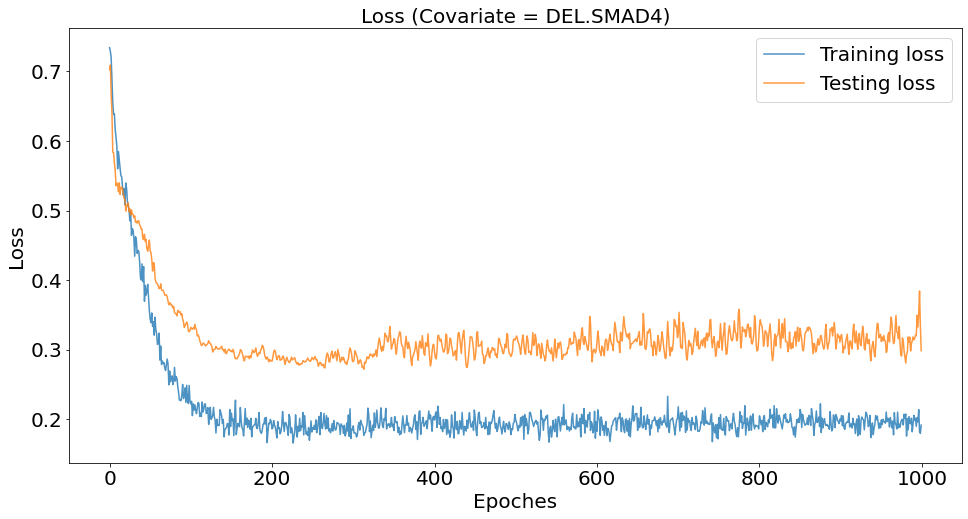

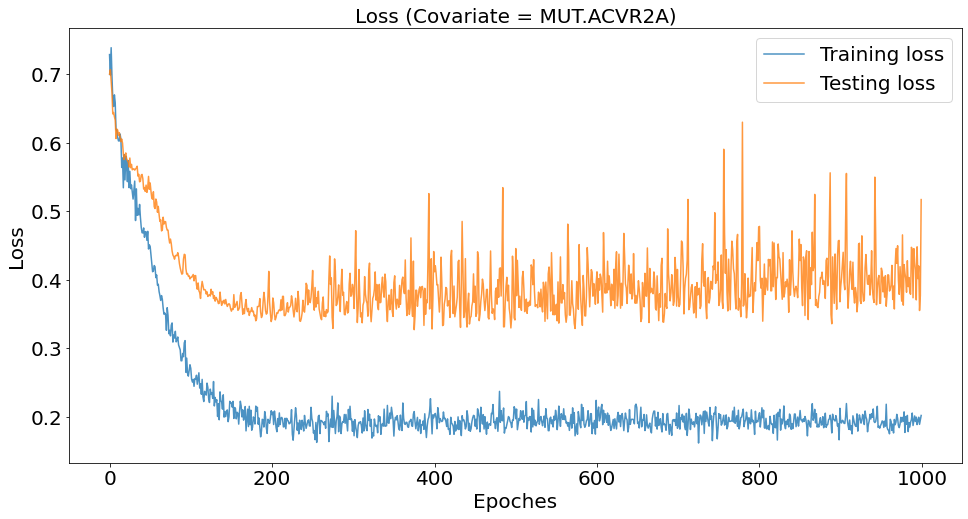

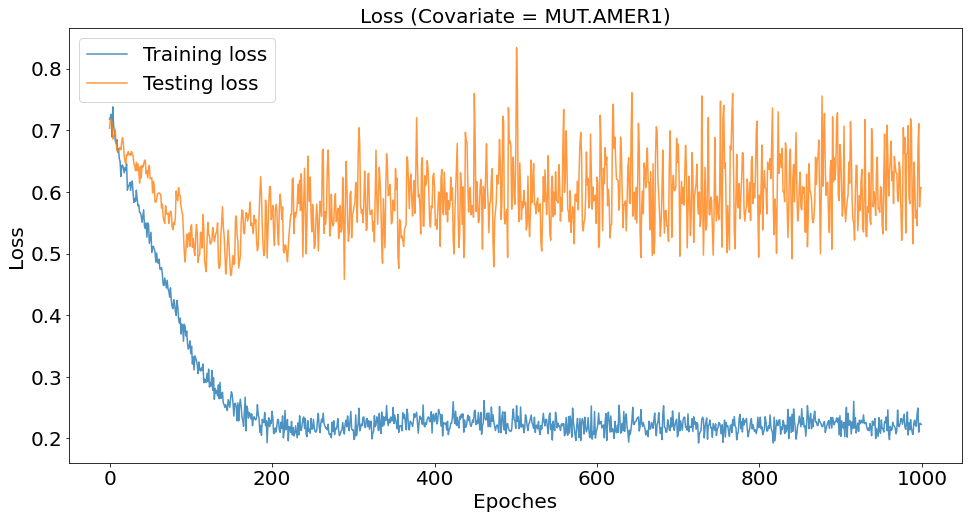

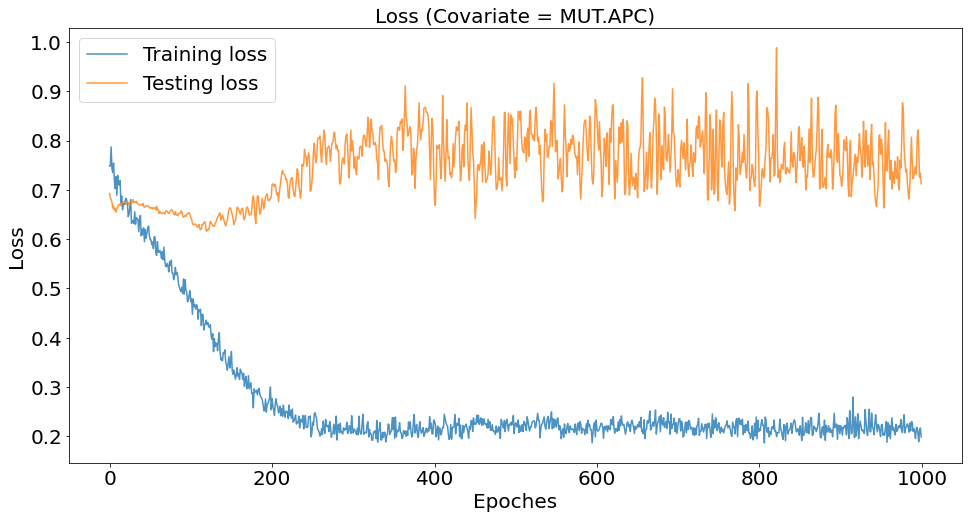

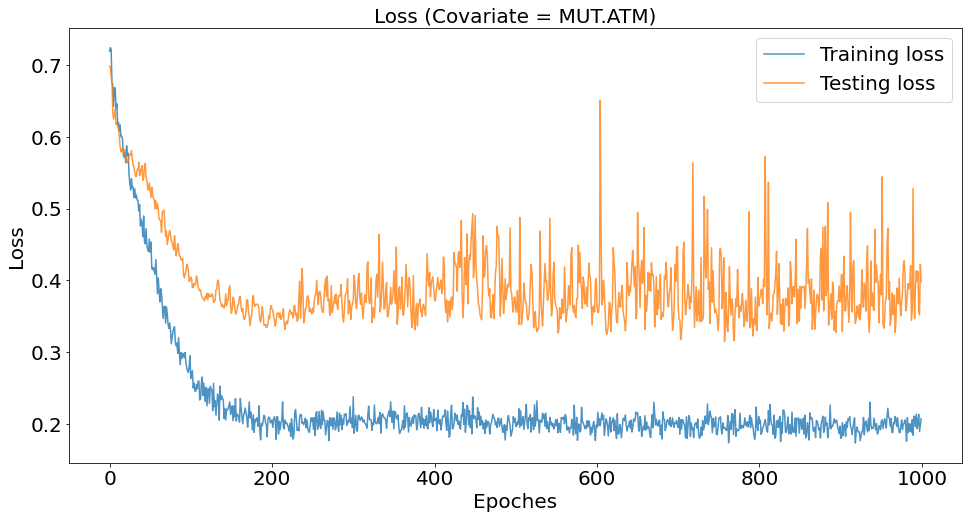

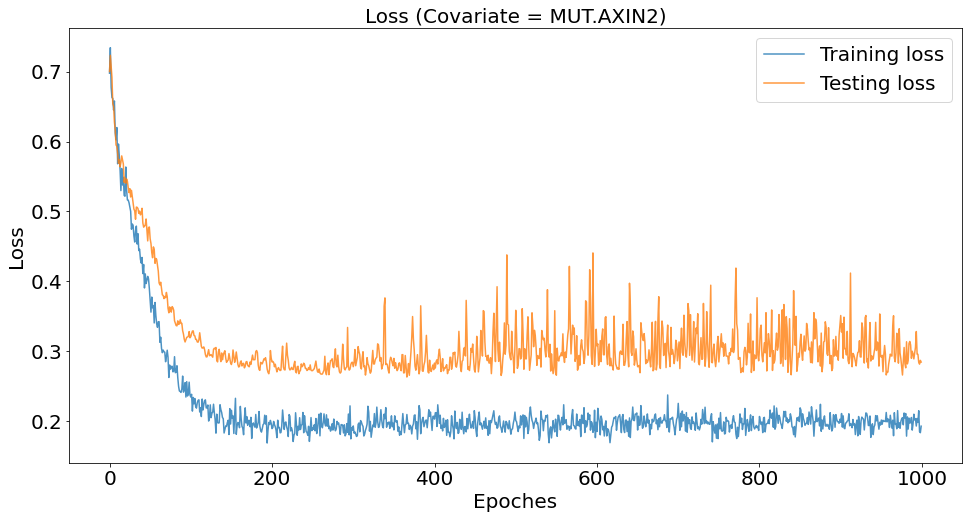

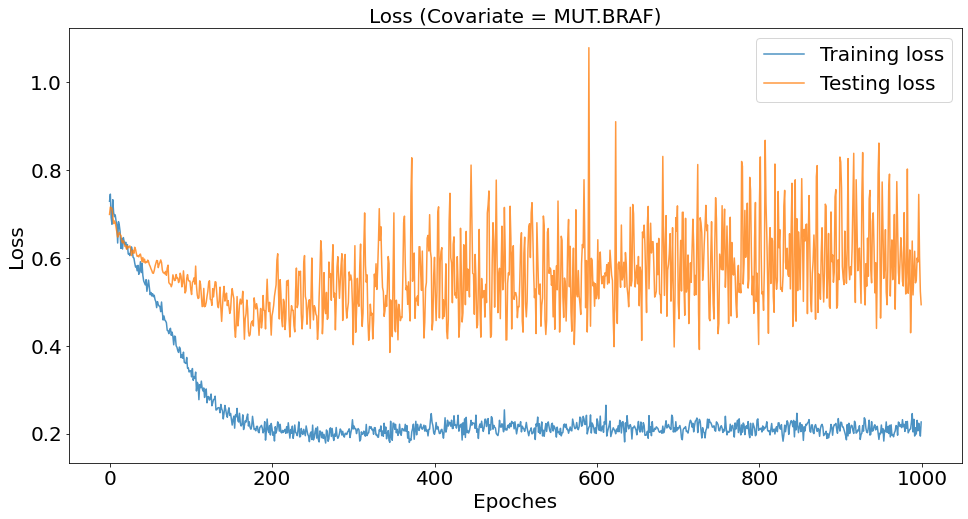

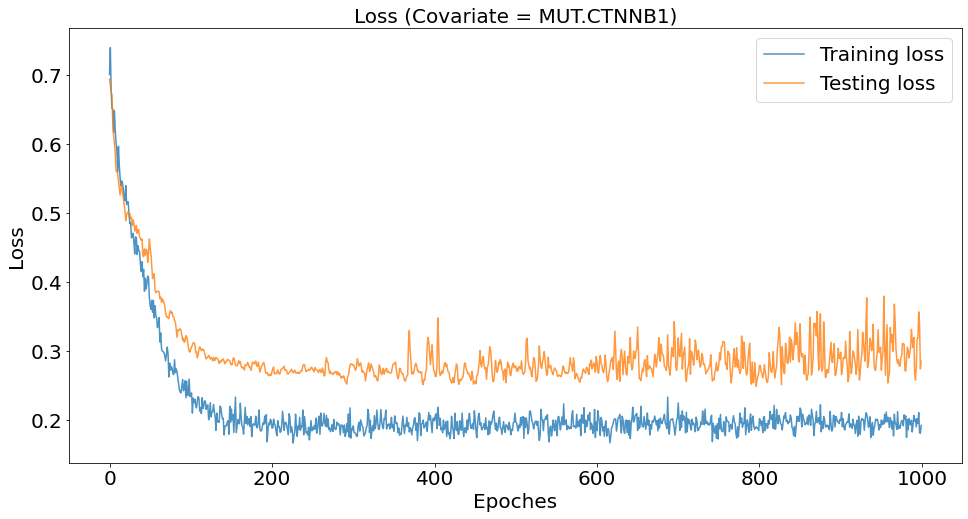

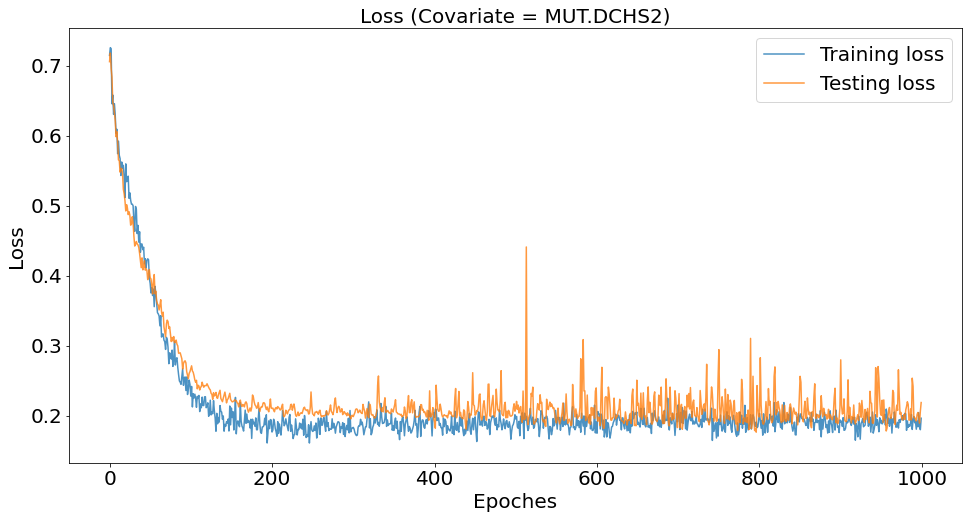

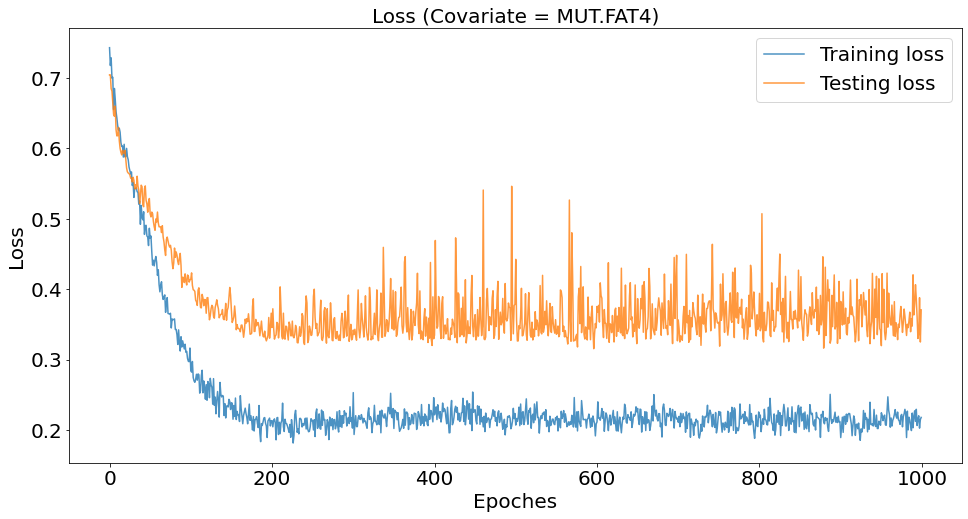

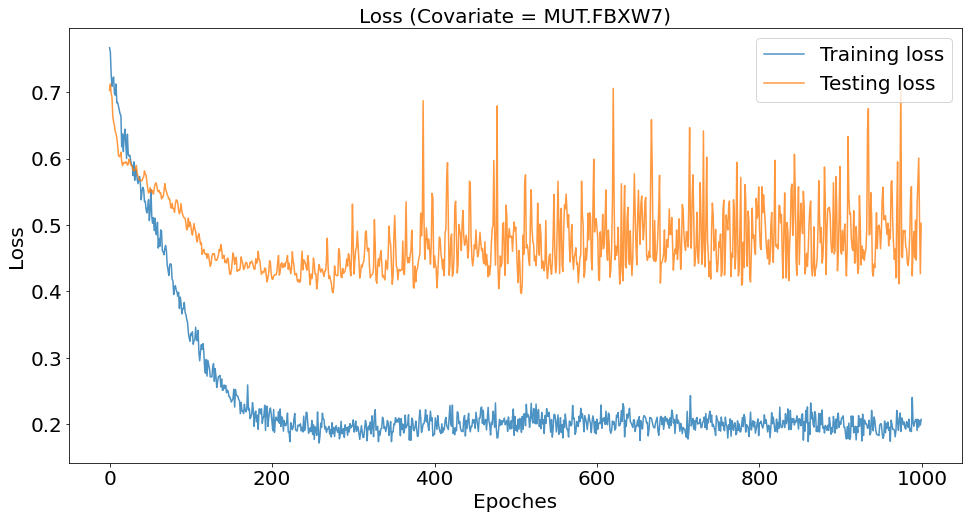

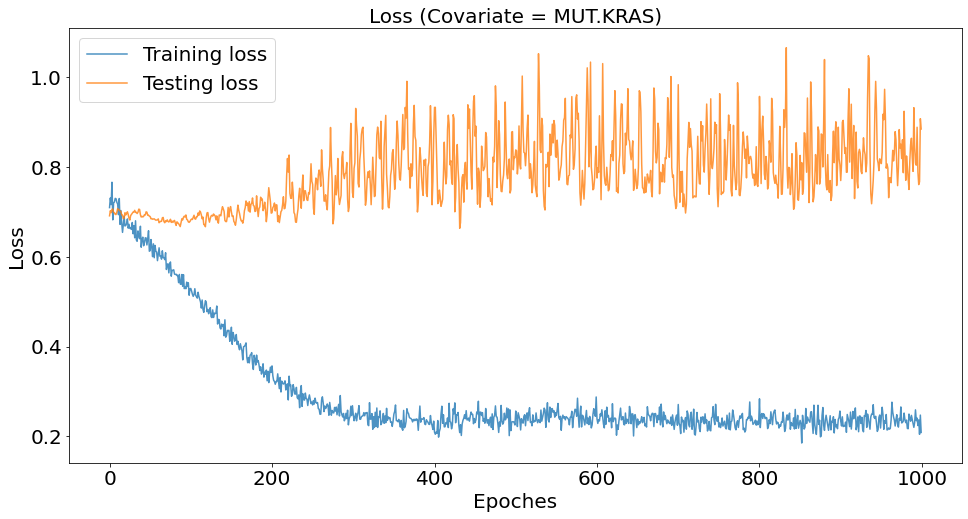

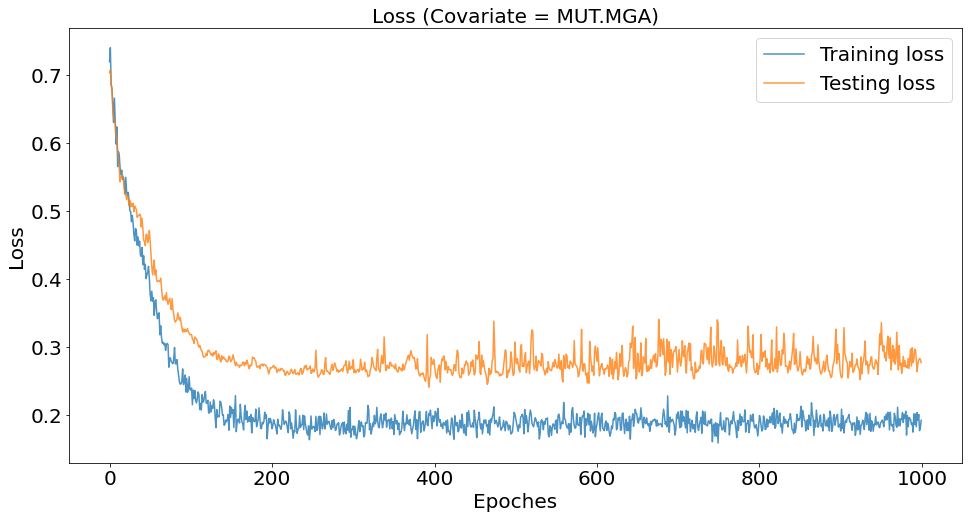

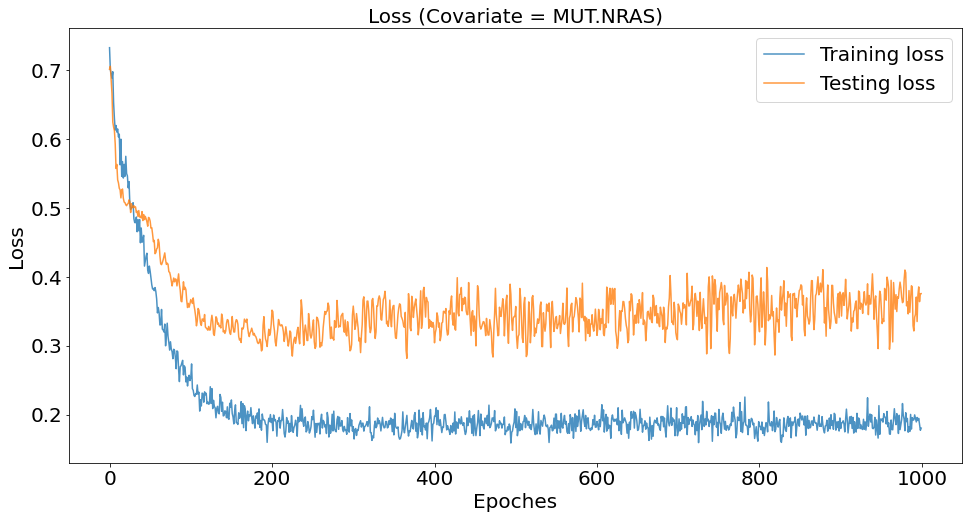

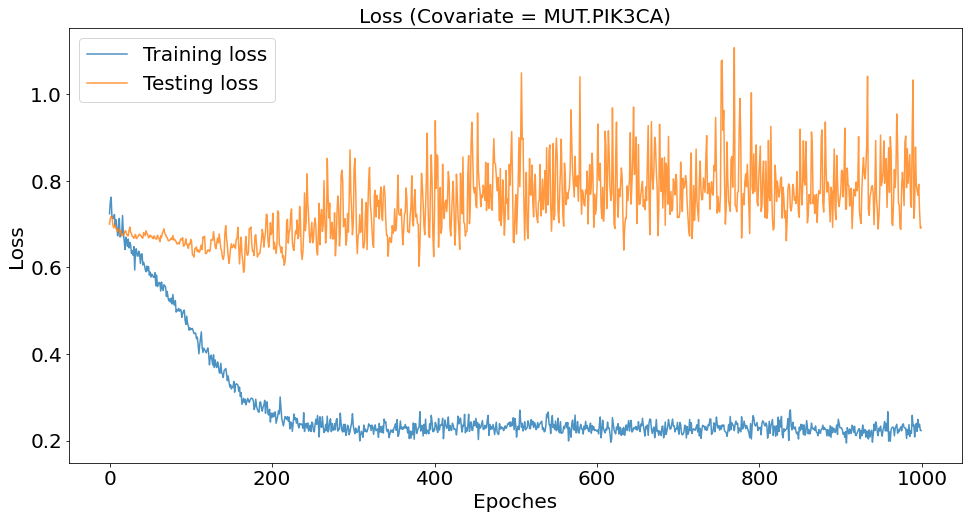

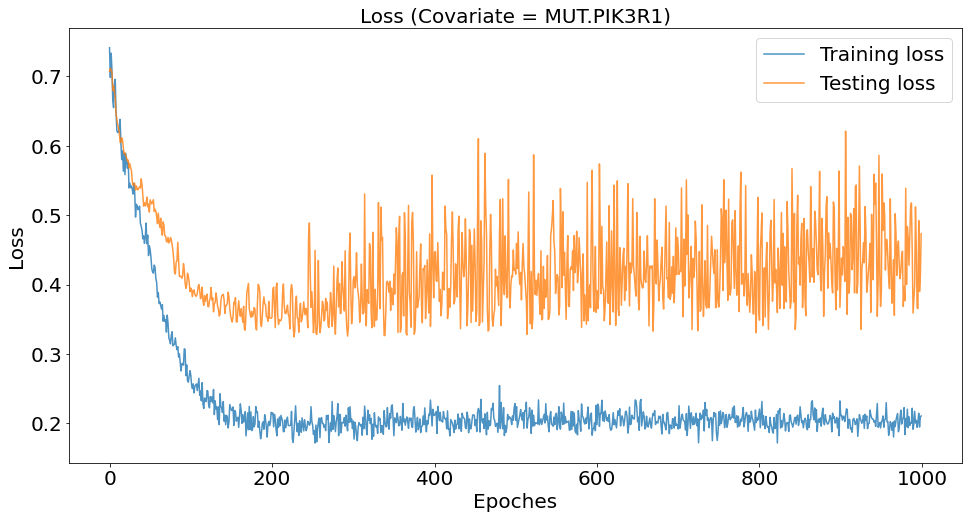

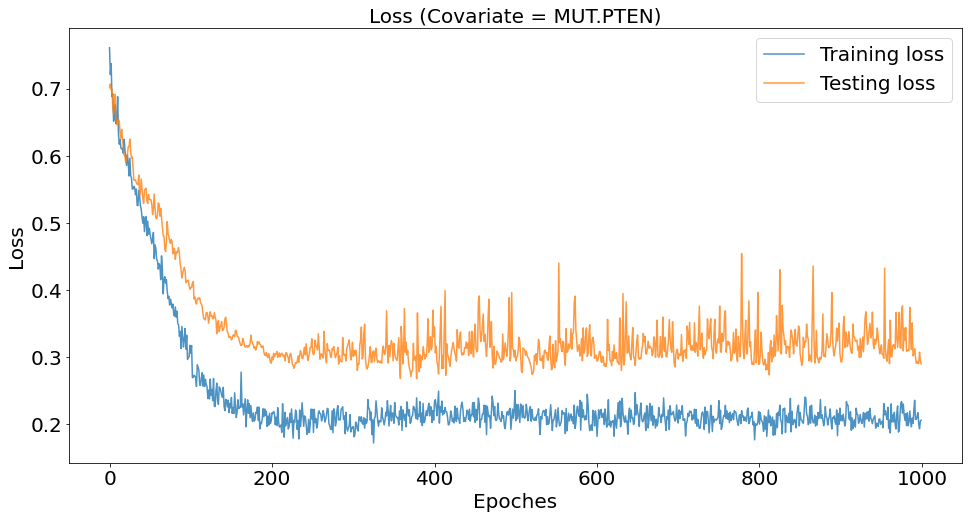

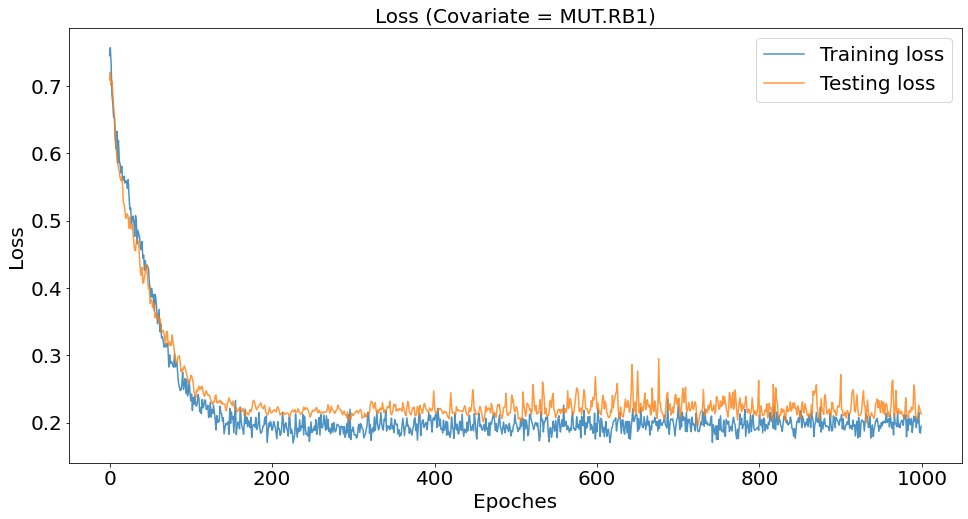

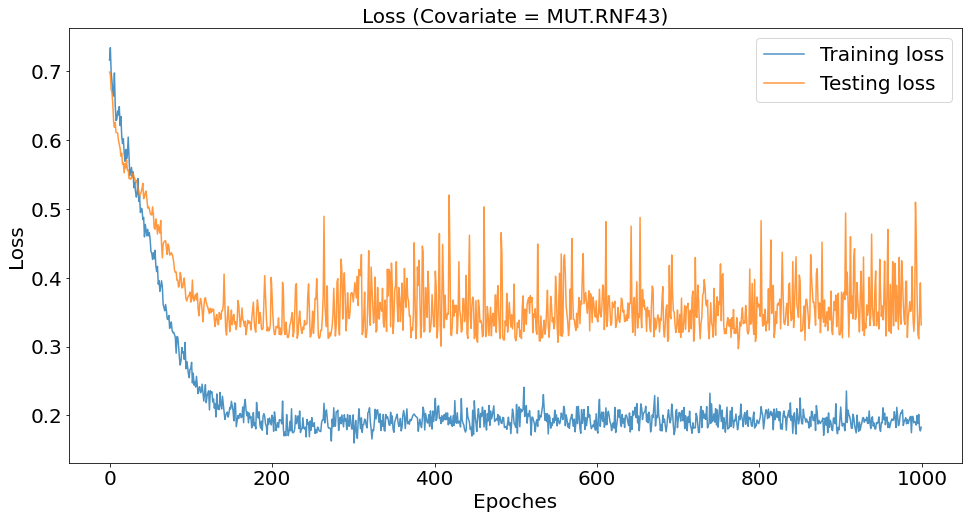

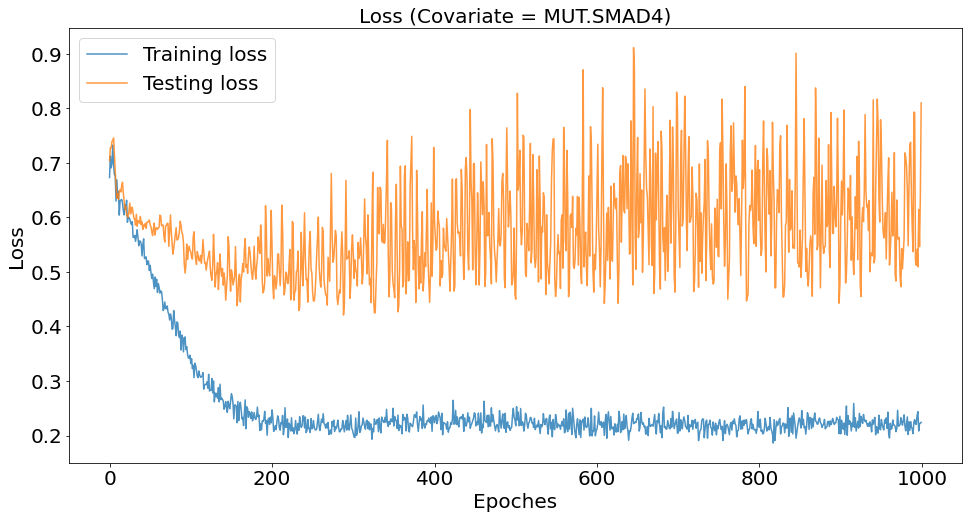

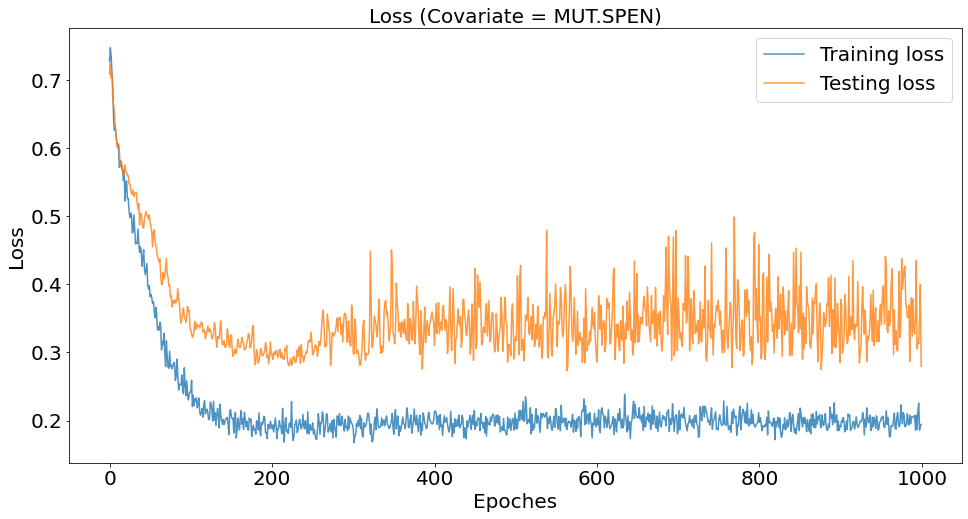

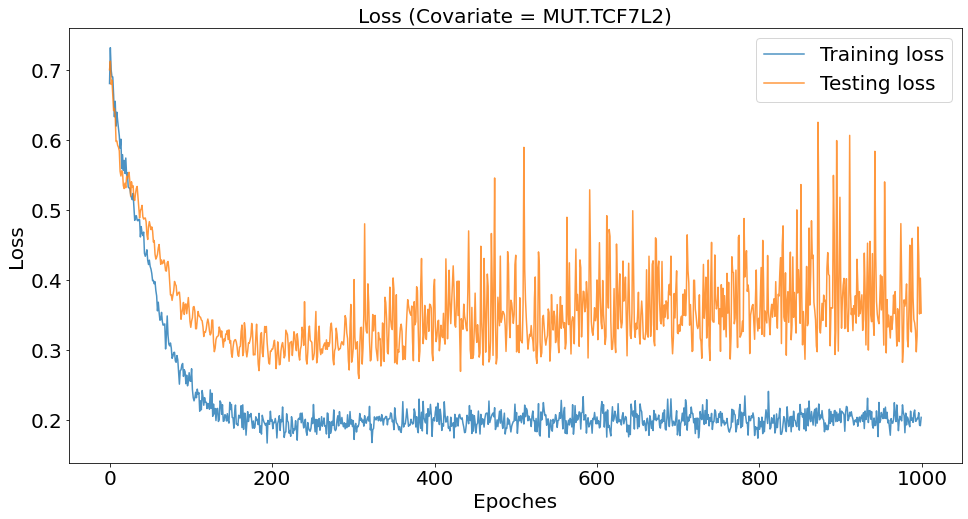

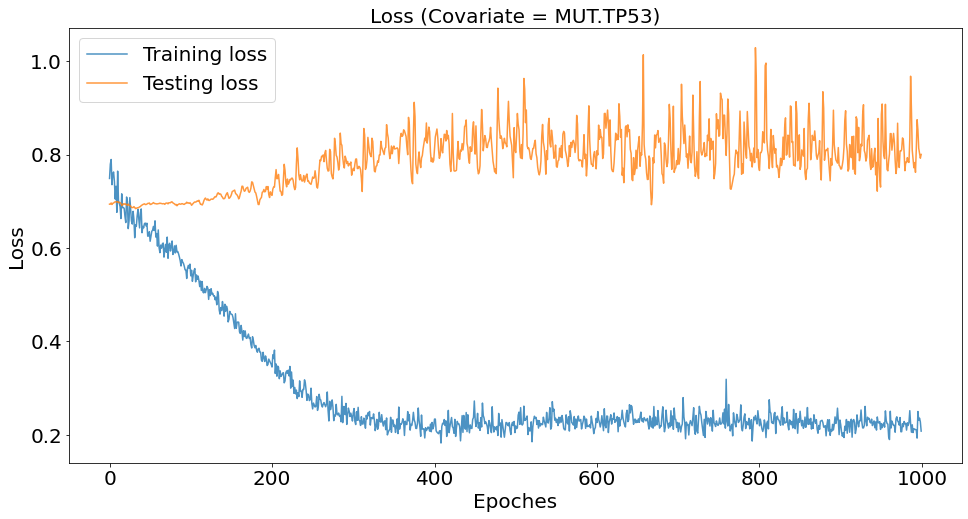

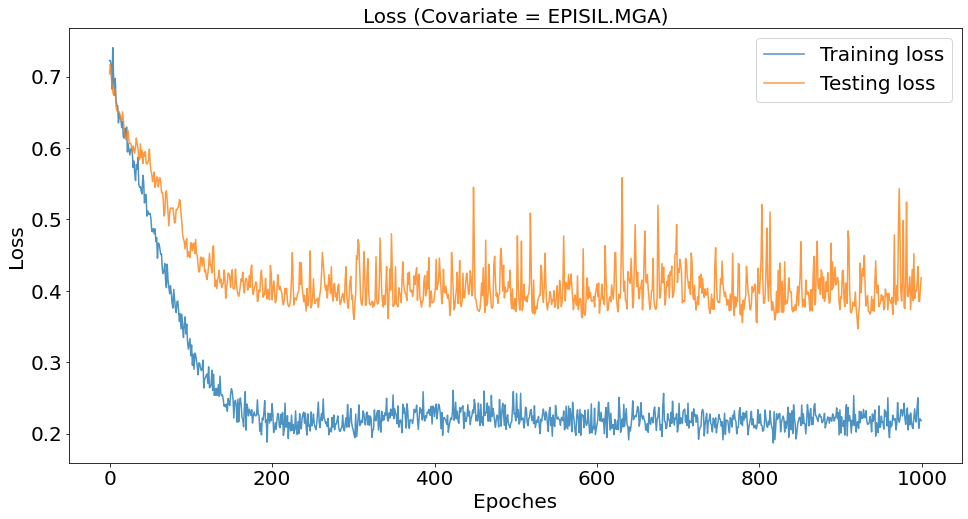

CPU times: user 18min 43s, sys: 16.7 s, total: 19min
Wall time: 15min 51s


In [21]:
%%time
COAD_prediction_result_dict = train_mlp_all_cols('COAD', device=device, true_percentage_cutoff=0.04)

In [22]:
COAD_prediction_result_dict['auc']

{'AMP.E2F1': 0.20967741935483875,
 'AMP.MYC': 0.0625,
 'DEL.FAT1': 0.564516129032258,
 'DEL.PTEN': 0.03225806451612906,
 'DEL.SMAD4': 0.435483870967742,
 'MUT.ACVR2A': 0.1666666666666666,
 'MUT.AMER1': 0.6379310344827586,
 'MUT.APC': 0.5956521739130435,
 'MUT.ATM': 0.5444444444444444,
 'MUT.AXIN2': 0.46774193548387094,
 'MUT.BRAF': 0.4642857142857143,
 'MUT.CTNNB1': 0.7580645161290323,
 'MUT.DCHS2': 0.90625,
 'MUT.FAT4': 0.5666666666666667,
 'MUT.FBXW7': 0.4857142857142857,
 'MUT.KRAS': 0.4444444444444445,
 'MUT.MGA': 0.7419354838709677,
 'MUT.NRAS': 0.8548387096774193,
 'MUT.PIK3CA': 0.31999999999999995,
 'MUT.PIK3R1': 0.38888888888888884,
 'MUT.PTEN': 0.711111111111111,
 'MUT.RB1': 0.96875,
 'MUT.RNF43': 0.7555555555555554,
 'MUT.SMAD4': 0.31034482758620696,
 'MUT.SPEN': 0.6129032258064516,
 'MUT.TCF7L2': 0.5967741935483871,
 'MUT.TP53': 0.5629629629629629,
 'EPISIL.MGA': 0.6206896551724138}

In [31]:
len(list(COAD_prediction_result_dict['auc'].keys()))

28

In [23]:
np.sort(list(COAD_prediction_result_dict['auc'].values()))[::-1]

array([0.96875   , 0.90625   , 0.85483871, 0.75806452, 0.75555556,
       0.74193548, 0.71111111, 0.63793103, 0.62068966, 0.61290323,
       0.59677419, 0.59565217, 0.56666667, 0.56451613, 0.56296296,
       0.54444444, 0.48571429, 0.46774194, 0.46428571, 0.44444444,
       0.43548387, 0.38888889, 0.32      , 0.31034483, 0.20967742,
       0.16666667, 0.0625    , 0.03225806])

### STAD

(380, 31)


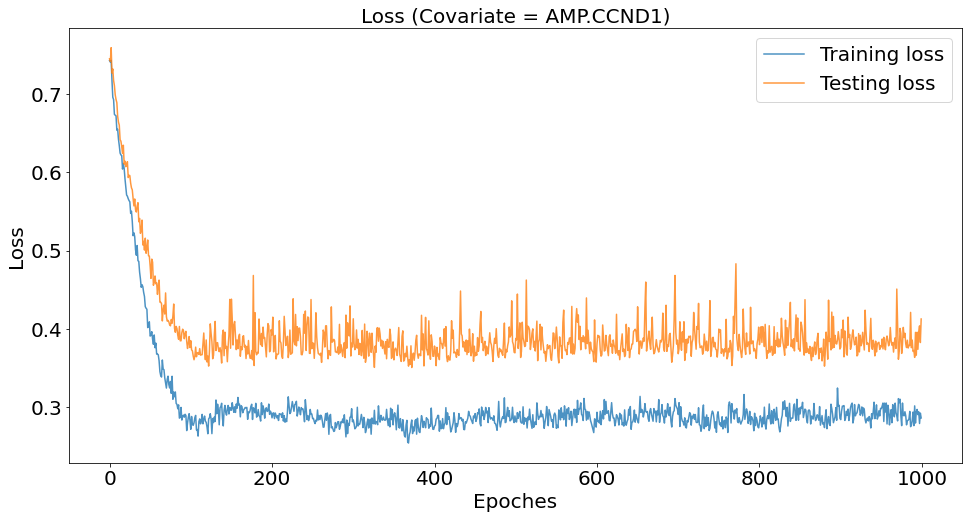

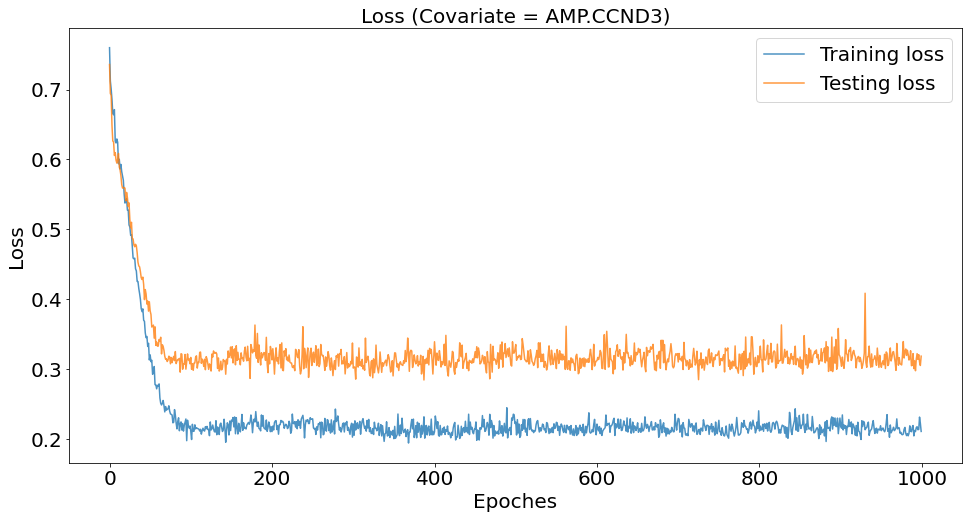

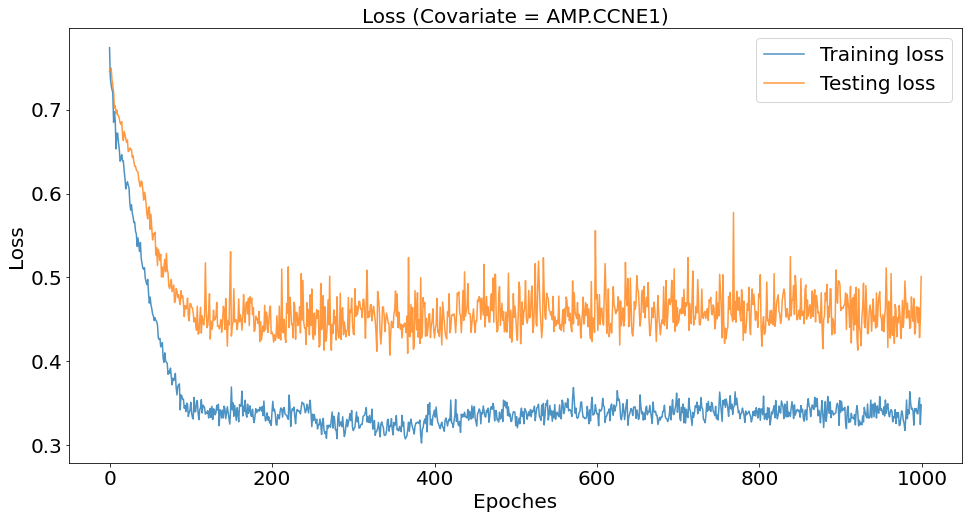

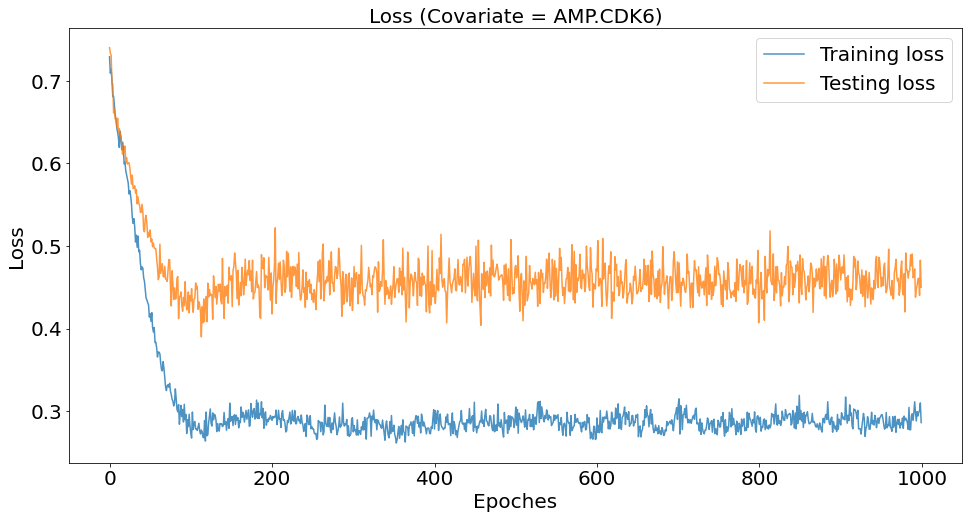

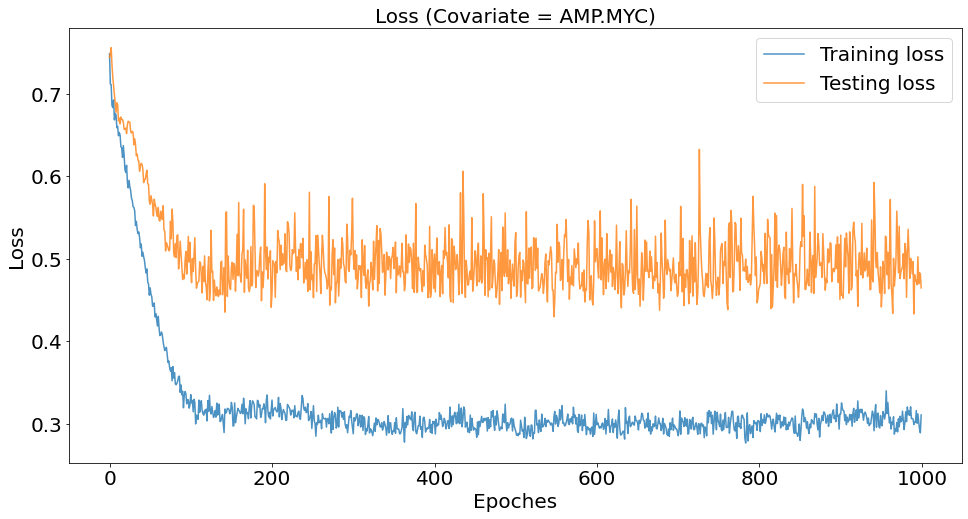

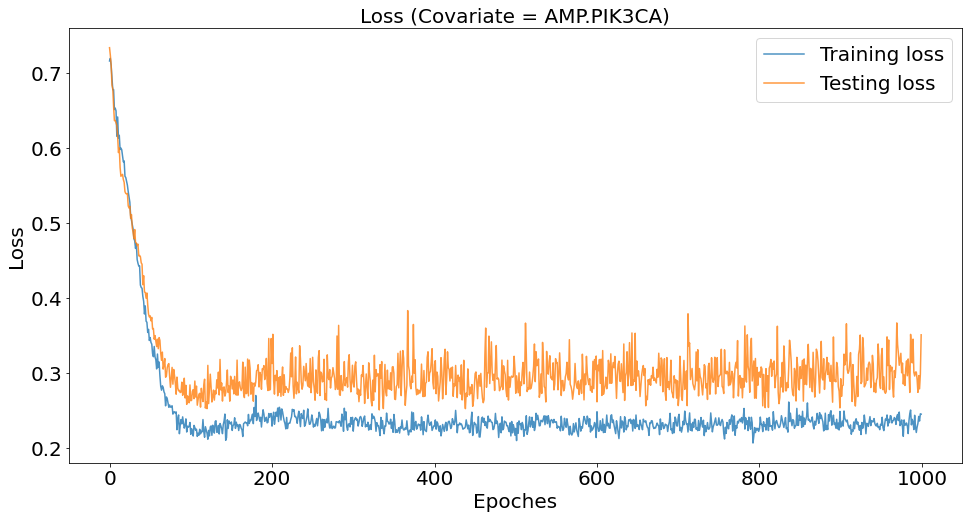

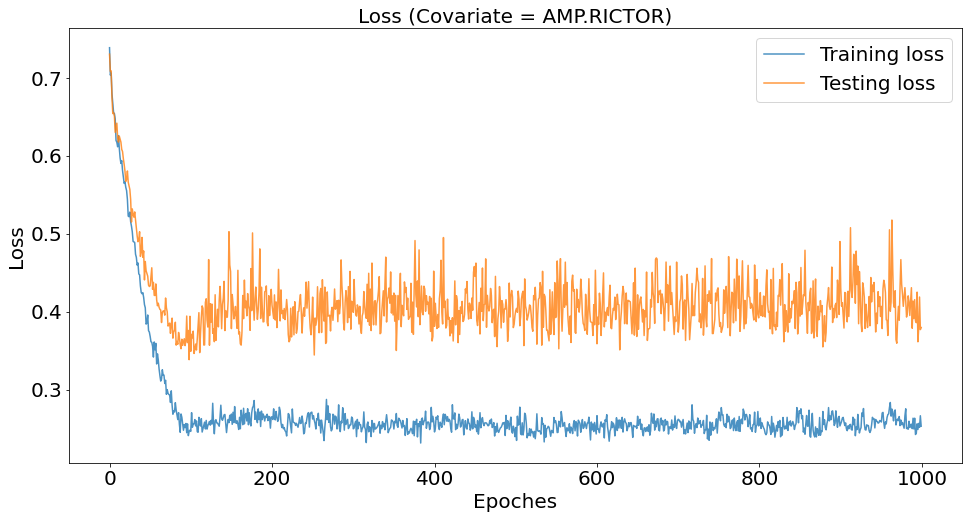

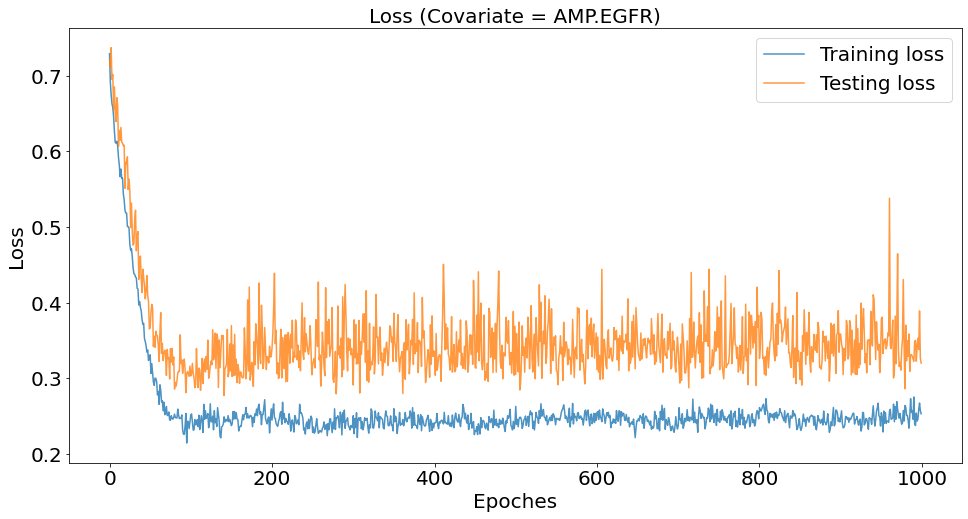

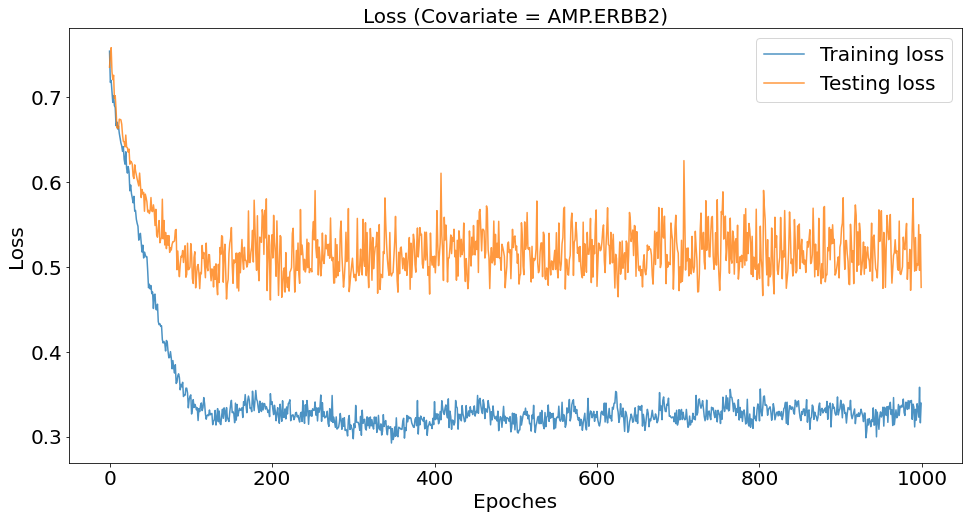

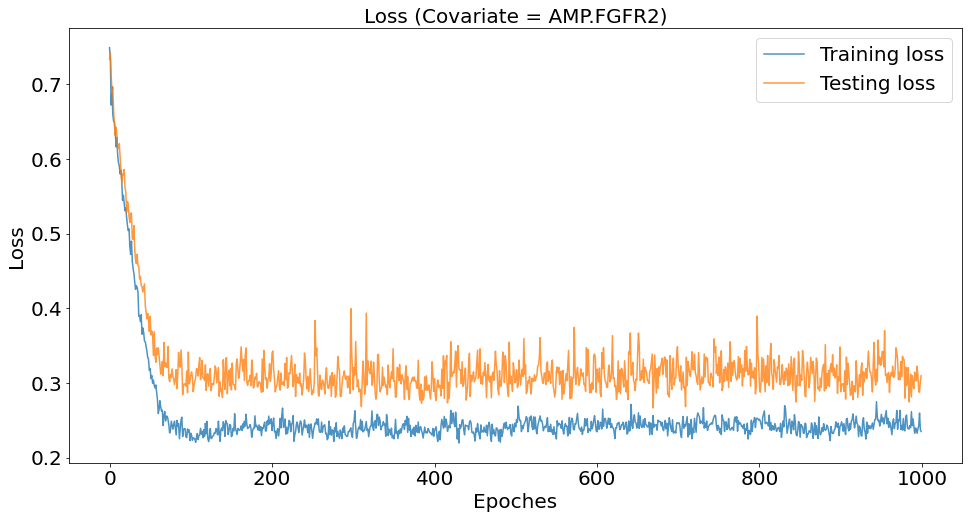

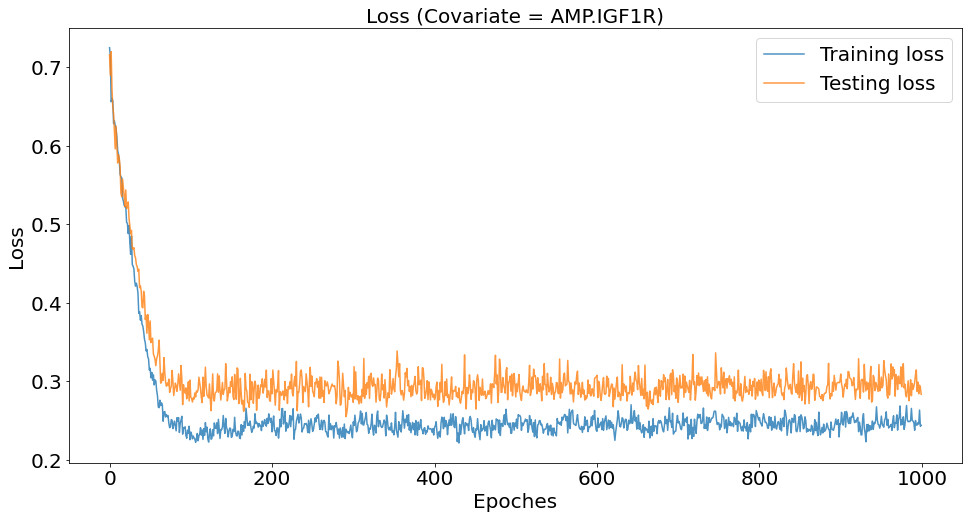

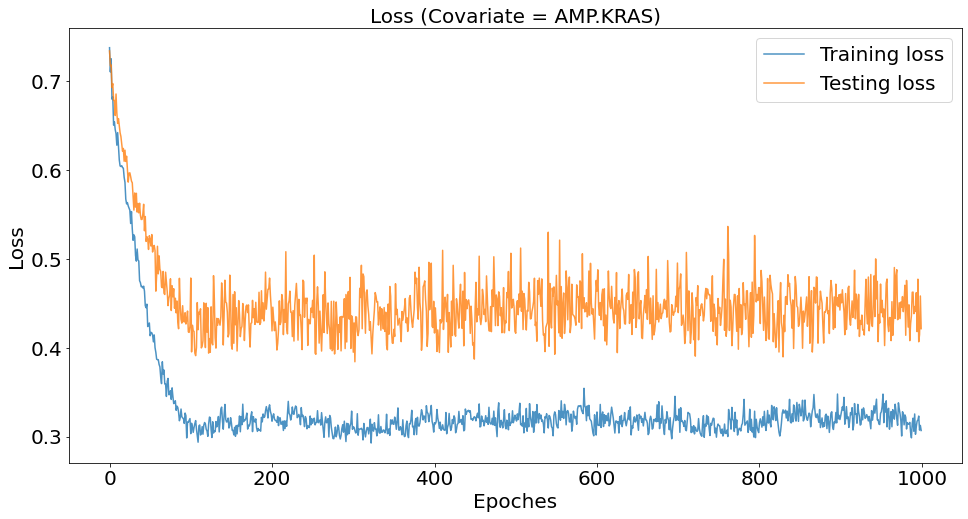

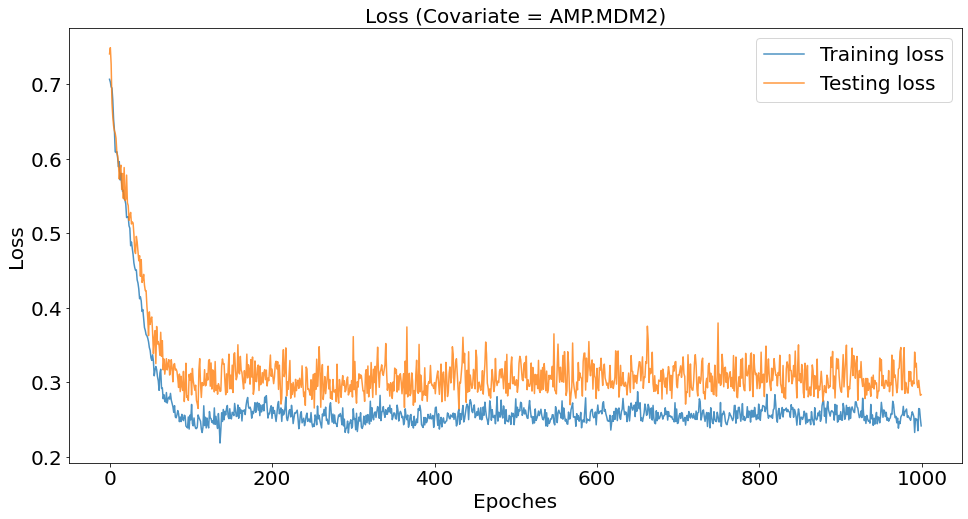

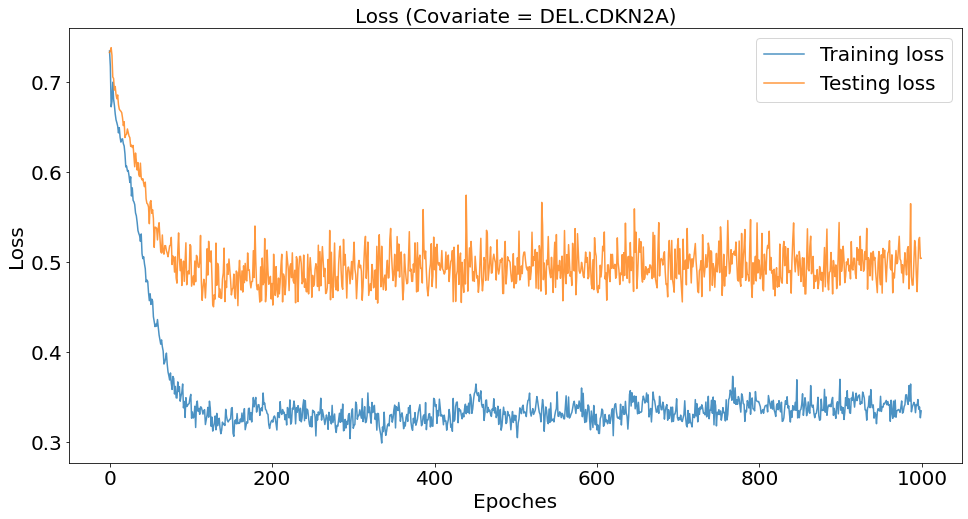

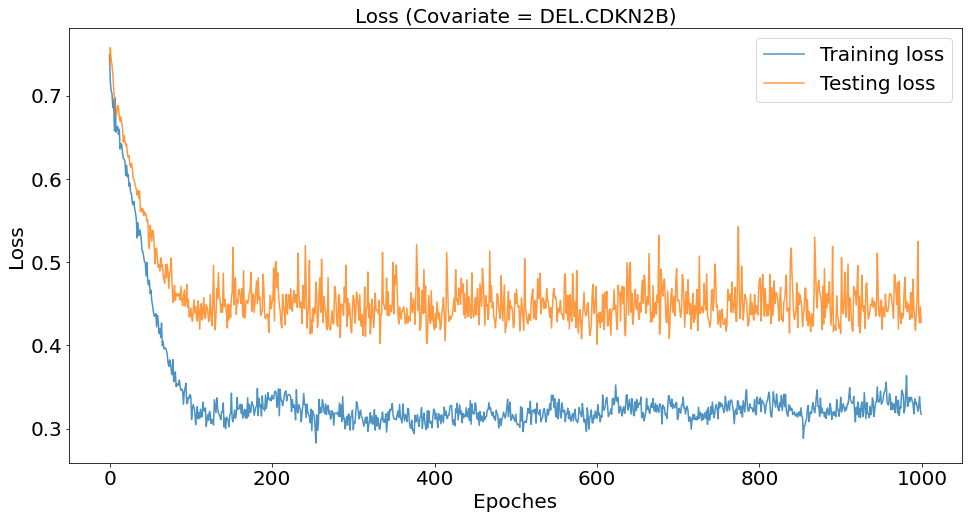

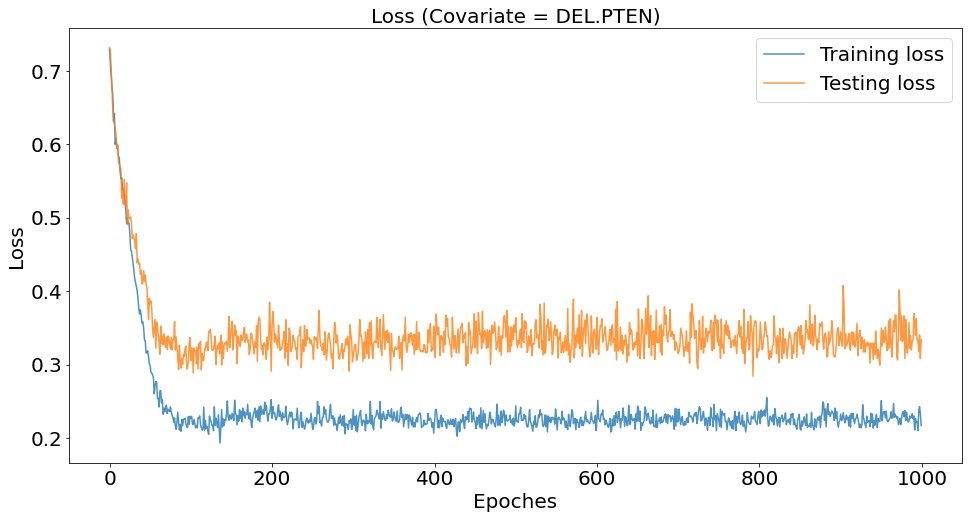

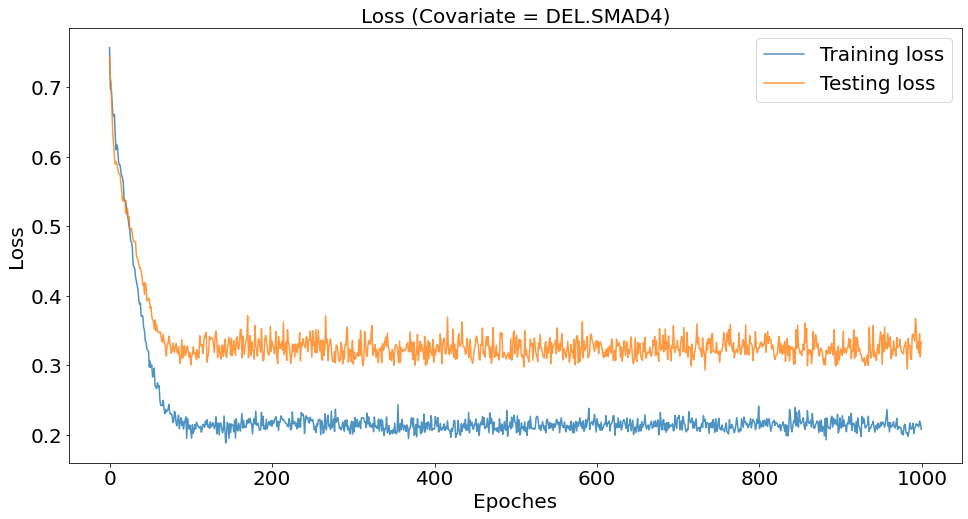

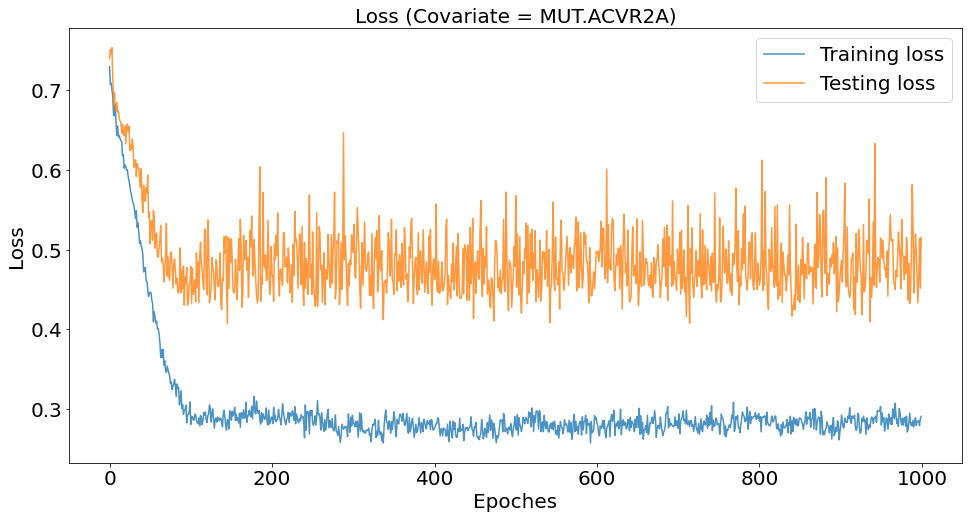

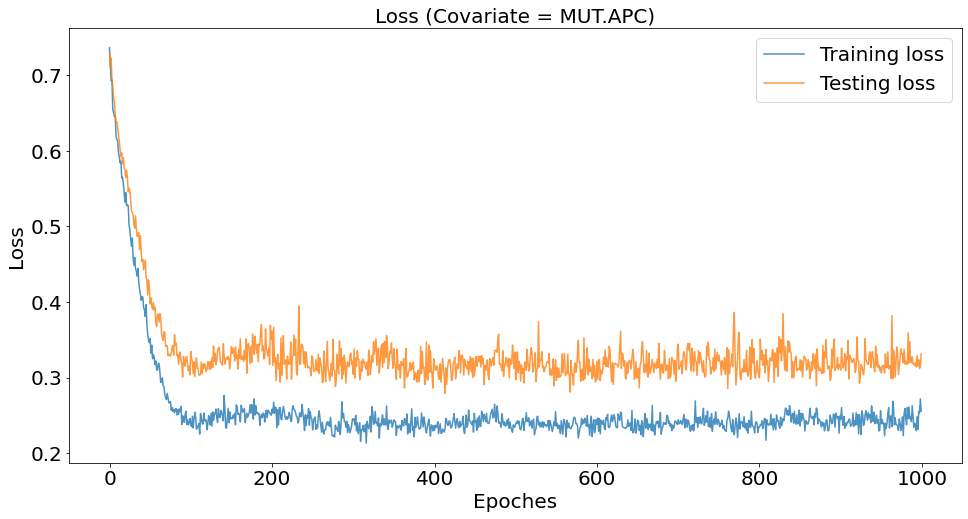

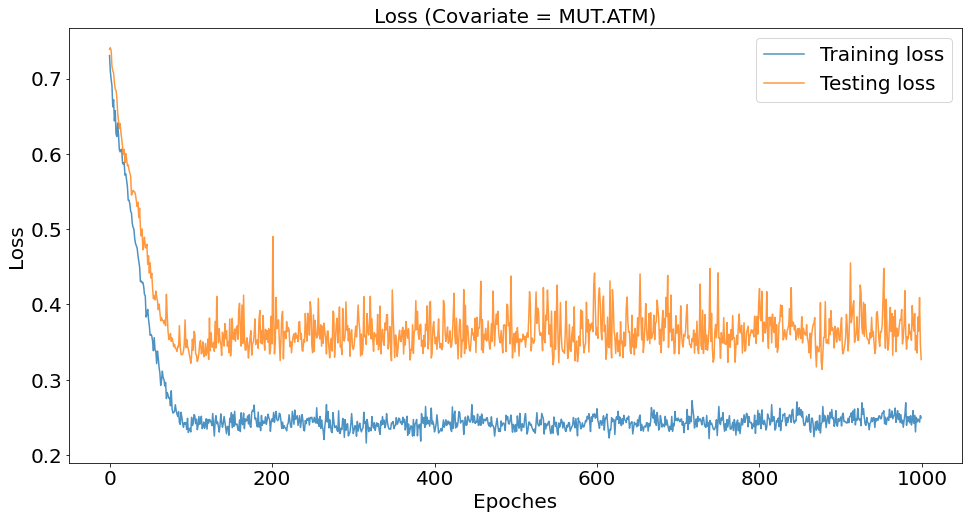

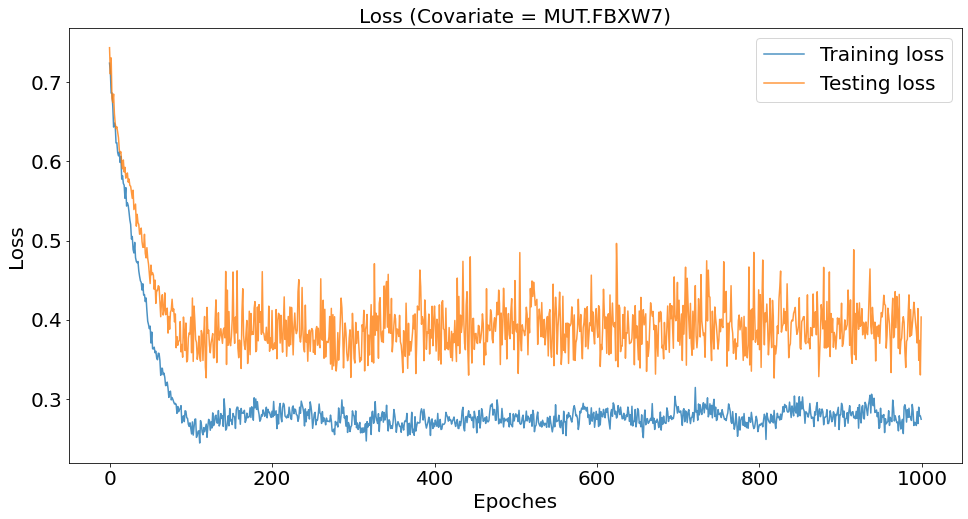

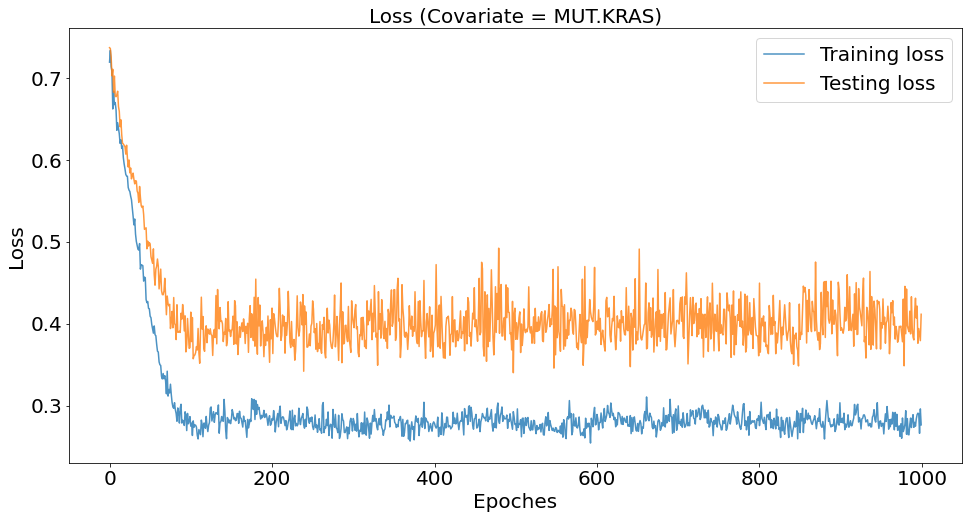

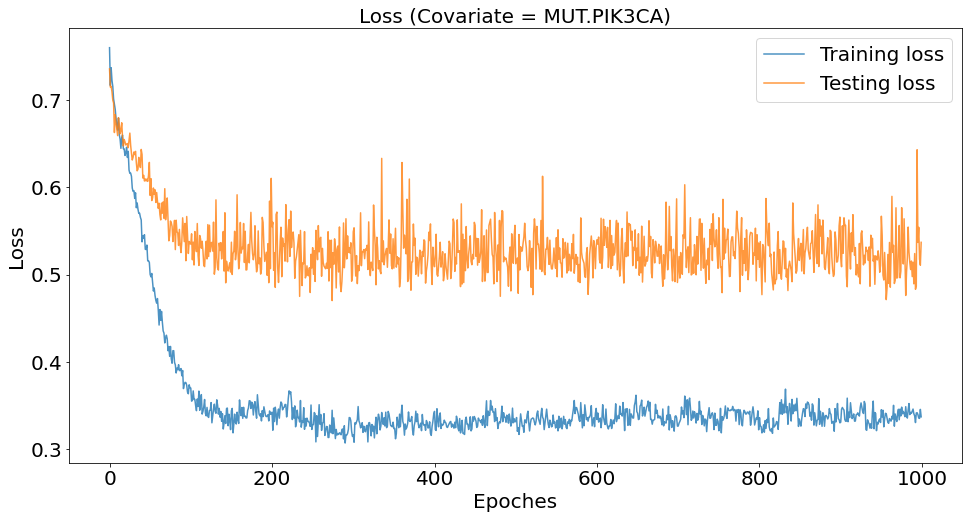

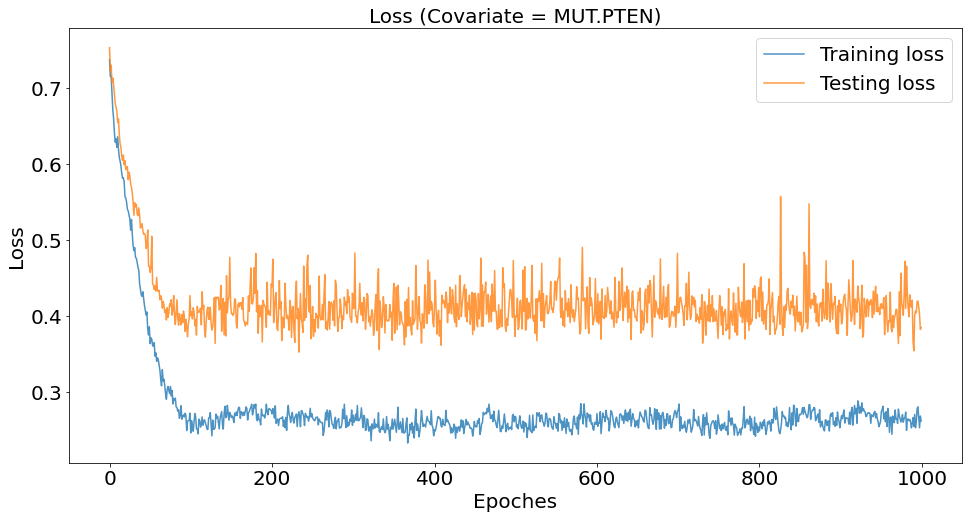

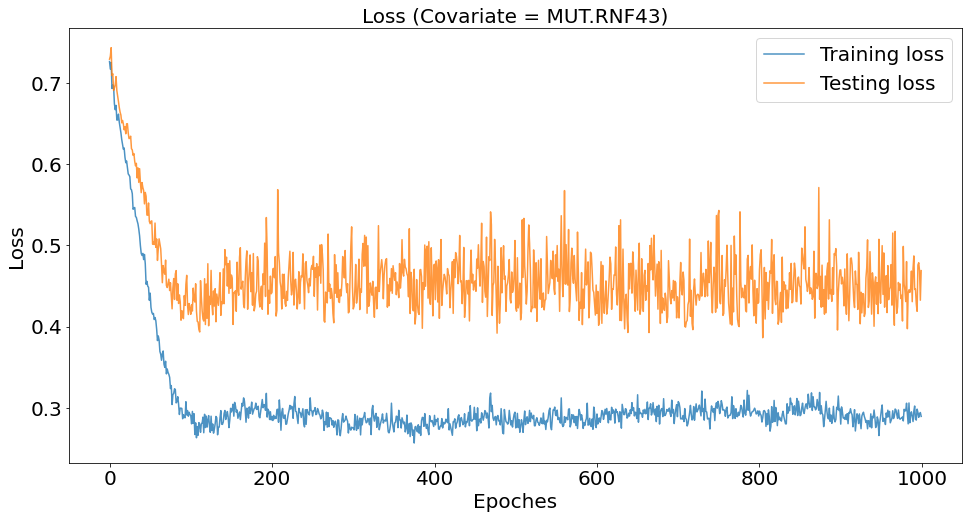

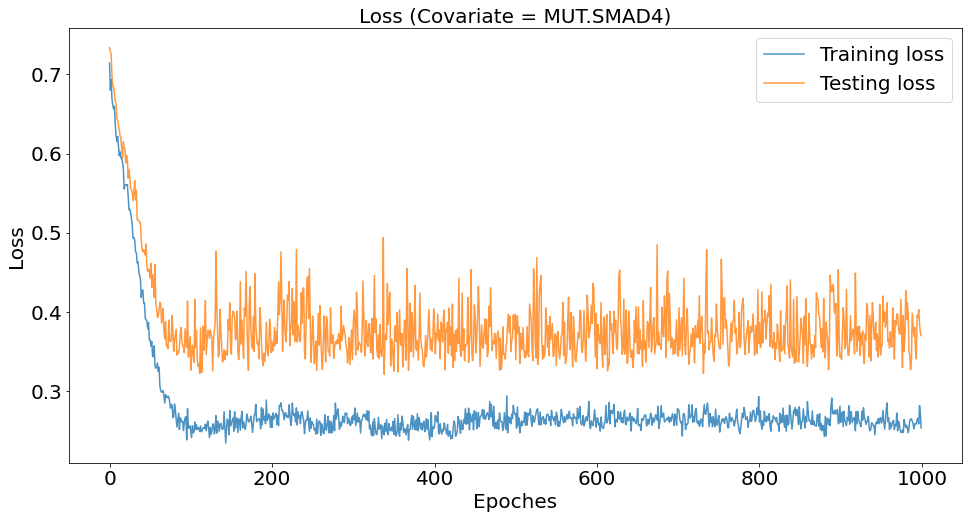

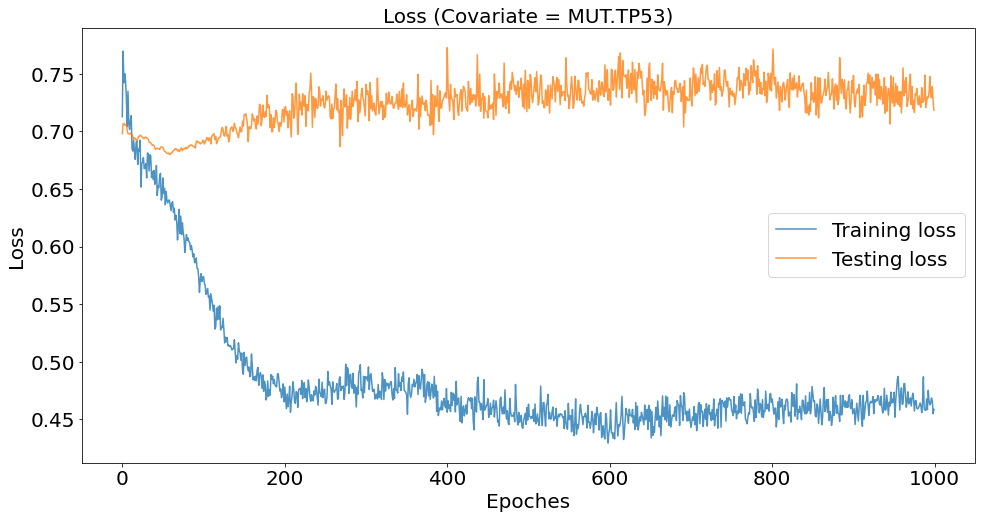

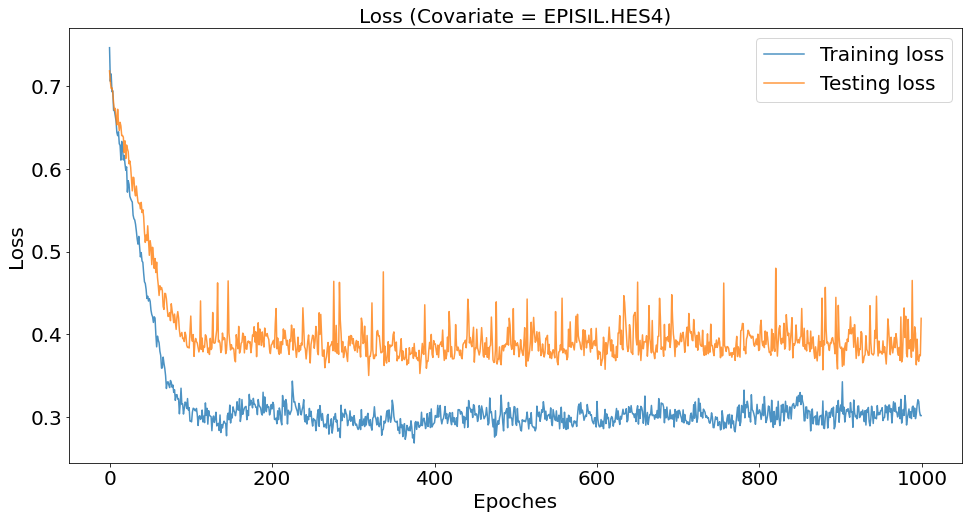

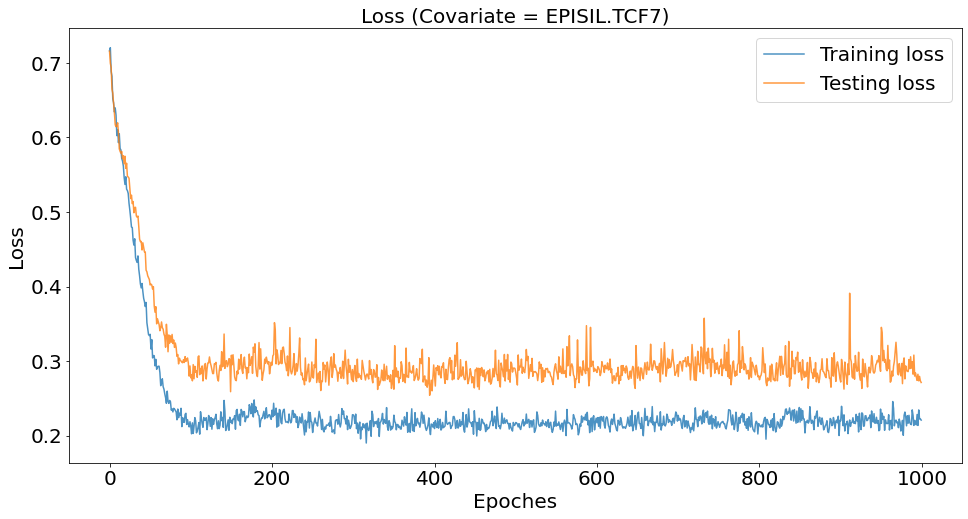

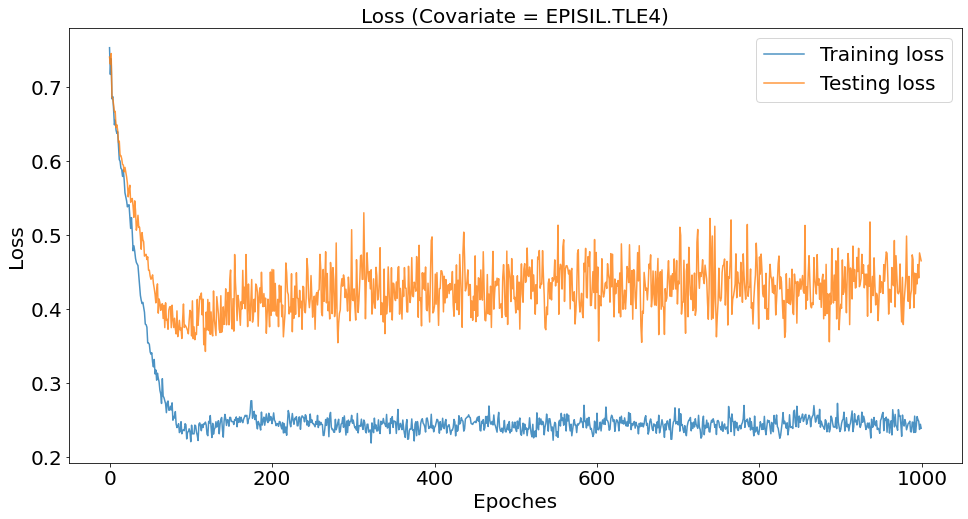

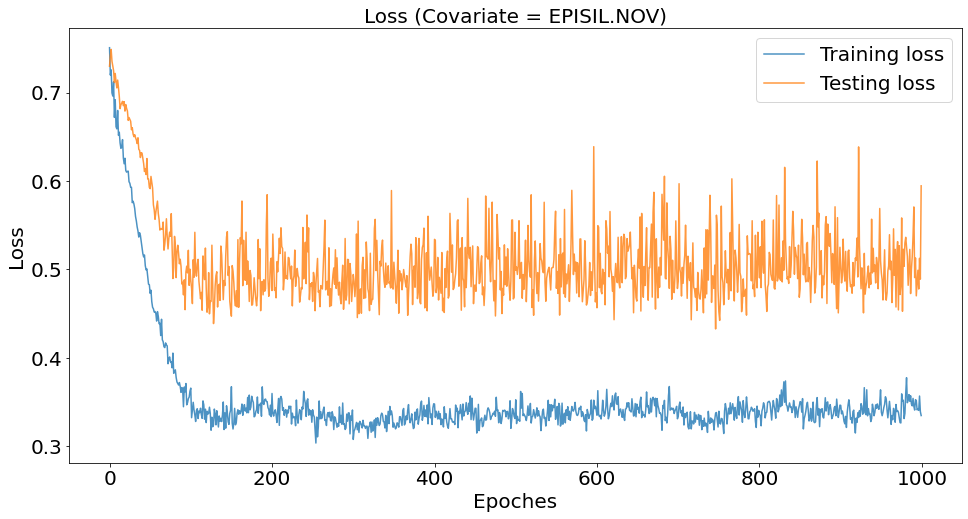

CPU times: user 42min 38s, sys: 29.1 s, total: 43min 7s
Wall time: 39min 19s


In [24]:
%%time
STAD_prediction_result_dict = train_mlp_all_cols('STAD', device=device, true_percentage_cutoff=0.04)

In [25]:
STAD_prediction_result_dict['auc']

{'AMP.CCND1': 0.6422535211267606,
 'AMP.CCND3': 0.7774647887323944,
 'AMP.CCNE1': 0.6213235294117647,
 'AMP.CDK6': 0.4726190476190476,
 'AMP.MYC': 0.4,
 'AMP.PIK3CA': 0.7430555555555556,
 'AMP.RICTOR': 0.6112676056338029,
 'AMP.EGFR': 0.5815972222222222,
 'AMP.ERBB2': 0.47762237762237764,
 'AMP.FGFR2': 0.4748858447488584,
 'AMP.IGF1R': 0.5707762557077626,
 'AMP.KRAS': 0.6056338028169014,
 'AMP.MDM2': 0.5091324200913241,
 'DEL.CDKN2A': 0.5157545605306799,
 'DEL.CDKN2B': 0.5688225538971807,
 'DEL.PTEN': 0.4722222222222222,
 'DEL.SMAD4': 0.8366197183098592,
 'MUT.ACVR2A': 0.5257352941176471,
 'MUT.APC': 0.6338028169014084,
 'MUT.ATM': 0.4140845070422535,
 'MUT.FBXW7': 0.4830985915492958,
 'MUT.KRAS': 0.5023809523809524,
 'MUT.PIK3CA': 0.5644531250000001,
 'MUT.PTEN': 0.3915492957746479,
 'MUT.RNF43': 0.3612836438923396,
 'MUT.SMAD4': 0.3042253521126761,
 'MUT.TP53': 0.4930555555555555,
 'EPISIL.HES4': 0.7650103519668736,
 'EPISIL.TCF7': 0.7267605633802817,
 'EPISIL.TLE4': 0.47142857142857

In [30]:
len(list(STAD_prediction_result_dict['auc'].keys()))

31

In [26]:
np.sort(list(STAD_prediction_result_dict['auc'].values()))[::-1]

array([0.83661972, 0.77746479, 0.76501035, 0.74305556, 0.72676056,
       0.64225352, 0.63380282, 0.62132353, 0.61126761, 0.6056338 ,
       0.58159722, 0.57077626, 0.56882255, 0.56445313, 0.52573529,
       0.51575456, 0.50913242, 0.50238095, 0.49305556, 0.48309859,
       0.47762238, 0.47488584, 0.47261905, 0.47222222, 0.47142857,
       0.41408451, 0.4       , 0.3915493 , 0.38474295, 0.36128364,
       0.30422535])

In [27]:
STAD_prediction_result_dict.keys()

dict_keys(['accuracy', 'auc', 'y_pred', 'confusion_matrix', 'pred_proba', 'classes', 'y_train_test'])

In [28]:
STAD_prediction_result_dict['confusion_matrix']['DEL.SMAD4']

array([[68,  3],
       [ 5,  0]])

In [29]:
STAD_prediction_result_dict['y_pred']['AMP.PIK3CA']

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False])